# Hyperparameter Tuning and Model Optimization for Credit Risk Prediction

## Overview

This notebook focuses on hyperparameter tuning and model optimization to maximize predictive performance for credit default prediction. Hyperparameter tuning is a critical step in the machine learning pipeline that distinguishes production-ready models from baseline prototypes.

## Model Selection vs Hyperparameter Tuning

**Model selection** involves choosing the appropriate algorithm family (e.g., linear models, tree-based ensembles, neural networks) based on problem characteristics, interpretability requirements, and computational constraints. **Hyperparameter tuning** optimizes the configuration of a chosen model to maximize performance on the specific dataset.

For credit risk prediction, we evaluate:
- **Logistic Regression**: Linear baseline model offering interpretability and regulatory compliance
- **Random Forest**: Non-linear ensemble method handling complex interactions and providing feature importance

## Why Default Hyperparameters Are Suboptimal

Machine learning libraries provide default hyperparameters designed to work reasonably well across diverse problems, but they are rarely optimal for specific datasets. Default values represent a compromise between:
- Computational efficiency (fast training for quick prototyping)
- Generalization (avoiding overfitting on unknown data distributions)
- Broad applicability (working across different problem types)

Dataset-specific characteristics—such as sample size, feature dimensionality, class imbalance ratio, and noise levels—require tailored hyperparameter configurations to achieve optimal performance.

## The Optimization Landscape

Hyperparameter optimization explores a high-dimensional space where parameters interact non-linearly. Key challenges include:
- **Computational cost**: Each evaluation requires full model training and cross-validation
- **Local optima**: The objective function may have multiple peaks
- **Interaction effects**: Optimal value of one parameter depends on values of others
- **Diminishing returns**: Performance improvements decrease as search progresses

## Search Strategies

We employ multiple search strategies with different tradeoffs:
- **Grid Search**: Exhaustive evaluation of discrete parameter combinations (comprehensive but expensive)
- **Random Search**: Random sampling from parameter distributions (efficient for large spaces)
- **Bayesian Optimization**: Probabilistic modeling of objective function (sample-efficient for expensive evaluations)

## Critical Consideration: Why Fine-Tuning Can Worsen Results

**A counterintuitive but important reality**: Hyperparameter tuning does not guarantee improved performance and can actually degrade model quality. This notebook addresses this phenomenon explicitly, examining six primary mechanisms of performance degradation:

1. **Overfitting to Validation Set**: Repeated evaluation causes information leakage from validation data into hyperparameter selection
2. **Suboptimal Search Space**: Predefined parameter ranges may exclude the global optimum
3. **Model Complexity Mismatch**: More complex models may not suit the underlying data pattern (Occam's razor)
4. **Computational Constraints**: Limited iterations may terminate before convergence
5. **Hyperparameter Interactions**: Non-linear dependencies between parameters complicate optimization
6. **Metric-Objective Misalignment**: Optimizing a single metric (e.g., AUC) may hurt business-relevant outcomes

Understanding these failure modes is essential for robust model development. We provide diagnostic methods and mitigation strategies for each mechanism throughout this notebook.

## Notebook Structure

1. **Feature Set Comparison**: Evaluate performance across different feature configurations
2. **Hyperparameter Optimization**: Systematic tuning of Random Forest and Logistic Regression
3. **Class Imbalance Handling**: Apply SMOTE to address minority class underrepresentation
4. **Comprehensive Evaluation**: Multi-metric assessment on hold-out test data
5. **Performance Degradation Analysis**: Diagnose and resolve tuning failures
6. **Threshold Optimization**: Align classification thresholds with business objectives

This systematic approach ensures models are both statistically sound and practically useful for credit risk assessment.

In [1]:
from pathlib import Path
import json
import pandas as pd

# load feature importance rankings
processed_dir = Path('data/processed')
importance_df = pd.read_csv('../data/processed/feature_importance_analysis.csv')

# load selected feature sets
with open(('../data/processed/selected_feature_sets.json'), 'r') as f:
    feature_sets = json.load(f)

print("available feature sets:")
for set_name, features in feature_sets.items():
    print(f"  {set_name}: {len(features)} features")

available feature sets:
  minimal_set: 3 features
  recommended_set: 4 features
  comprehensive_set: 4 features
  tier1_features: 3 features
  tier2_features: 1 features
  tier3_features: 0 features
  tier4_features: 22 features


## 1. Data Preparation and Splitting Strategy

### Why Proper Data Splitting Matters

Hyperparameter tuning requires a three-way data split to prevent information leakage and obtain unbiased performance estimates:

- **Training Set (70%)**: Used to fit model parameters (weights, tree structures)
- **Validation Set (15%)**: Used to evaluate hyperparameter configurations during tuning
- **Test Set (15%)**: Final hold-out set for unbiased performance assessment

The validation set serves as a proxy for unseen data during the tuning process. The test set remains completely hidden until final evaluation to provide an honest estimate of real-world performance.

### Stratification for Imbalanced Data

Credit default data exhibits significant class imbalance (~20-30% default rate). Stratified splitting ensures each subset maintains the same default rate as the original dataset, preventing:
- Training on non-representative samples
- Validation metrics with high variance
- Unreliable model selection decisions

### Data Preprocessing Requirements

Different algorithms have different preprocessing needs:
- **Logistic Regression**: Requires feature scaling (StandardScaler) because it uses distance-based optimization
- **Random Forest**: Works directly with raw features as tree splits are based on threshold comparisons, not distances
- **Categorical Encoding**: Label encoding for ordinal relationships, one-hot encoding for nominal categories

This section loads the model-ready dataset from feature engineering and establishes the proper data infrastructure for robust hyperparameter tuning.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report, roc_curve
)
from imblearn.over_sampling import SMOTE
import time

import pandas as pd
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import seaborn as sns

# set random seed for reproducibility
SEED = 2025
np.random.seed(SEED)

def generate_synthetic_credit_data(n_samples: int = 10000) -> pd.DataFrame:
    """
    generate synthetic credit risk data for demonstration
    
    args:
        n_samples: number of samples to generate
        
    returns:
        synthetic dataframe with credit features and target
    """
    np.random.seed(SEED)
    
    # grade encoding (A=1, B=2, etc.)
    grade = np.random.choice(range(1, 8), size=n_samples, p=[0.15, 0.20, 0.25, 0.20, 0.10, 0.07, 0.03])
    sub_grade = grade + np.random.uniform(-0.4, 0.4, size=n_samples)
    
    # interest rate correlated with grade
    int_rate_clean = 5 + (grade * 3) + np.random.normal(0, 2, n_samples)
    int_rate_clean = np.clip(int_rate_clean, 5, 30)
    
    # other features
    data = {
        'loan_amnt': np.random.uniform(1000, 40000, n_samples),
        'term_months': np.random.choice([36, 60], n_samples, p=[0.7, 0.3]),
        'int_rate_clean': int_rate_clean,
        'installment': np.random.uniform(50, 1500, n_samples),
        'grade': grade,
        'sub_grade': sub_grade,
        'emp_length_numeric': np.random.uniform(0, 10, n_samples),
        'home_ownership': np.random.choice([0, 1, 2], n_samples, p=[0.1, 0.5, 0.4]),
        'annual_inc': np.random.lognormal(10.5, 0.7, n_samples),
        'verification_status': np.random.choice([0, 1, 2], n_samples, p=[0.4, 0.3, 0.3]),
        'dti': np.random.uniform(0, 40, n_samples),
        'open_acc': np.random.poisson(10, n_samples),
        'pub_rec': np.random.poisson(0.1, n_samples),
        'revol_bal': np.random.uniform(0, 50000, n_samples),
        'revol_util_clean': np.random.uniform(0, 100, n_samples),
        'total_acc': np.random.poisson(20, n_samples),
        'initial_list_status': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        'application_type': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
        'mort_acc': np.random.poisson(1, n_samples),
        'pub_rec_bankruptcies': np.random.poisson(0.05, n_samples),
        'issue_year': np.random.choice(range(2015, 2021), n_samples),
        'issue_month': np.random.choice(range(1, 13), n_samples),
        'credit_history_years': np.random.uniform(2, 30, n_samples),
        'loan_to_income_ratio': np.random.uniform(0, 0.5, n_samples),
        'purpose': np.random.choice(range(0, 14), n_samples),
        'addr_state': np.random.choice(range(0, 50), n_samples),
    }
    
    df = pd.DataFrame(data)
    
    # generate target with realistic probability based on risk factors
    # higher grade, higher interest rate, higher DTI = higher default probability
    default_prob = (
        0.05 +  # base rate
        (grade - 1) * 0.03 +  # grade effect
        (int_rate_clean - 5) / 100 +  # interest rate effect
        df['dti'] / 500 +  # DTI effect
        (df['pub_rec'] > 0) * 0.05 +  # public records effect
        (df['pub_rec_bankruptcies'] > 0) * 0.08  # bankruptcy effect
    )
    default_prob = np.clip(default_prob, 0, 0.5)
    
    df['target'] = (np.random.random(n_samples) < default_prob).astype(int)
    
    print(f"generated {n_samples:,} synthetic samples")
    print(f"default rate: {df['target'].mean():.2%}")
    
    return df

def prepare_modelling_data(df: pd.DataFrame, target: str = 'target') -> Tuple:
    """
    prepare data for model training with proper encoding and splitting
    
    args:
        df: preprocessed dataframe
        target: target variable name
        
    returns:
        tuple of (X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders)
    """
    df_model_prep = df.copy()
    
    # separate features and target
    if target not in df_model_prep.columns:
        raise ValueError(f"target column '{target}' not found in dataframe")
    
    y = df_model_prep[target]
    X = df_model_prep.drop(columns=[target])
    
    # encode categorical variables
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    encoders = {}
    
    for col in categorical_cols:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        encoders[col] = le
    
    # convert datetime columns to numeric
    datetime_cols = X.select_dtypes(include=['datetime64']).columns.tolist()
    for col in datetime_cols:
        X[f'{col}_year'] = X[col].dt.year
        X[f'{col}_month'] = X[col].dt.month
        X = X.drop(columns=[col])
    
    feature_names = X.columns.tolist()
    
    # Set your upper and lower bounds
    lower_bound = -1e6
    upper_bound = 1e6

    # Apply across all numeric columns
    X = X.clip(lower=lower_bound, upper=upper_bound)
    
    # split data: 70% train, 15% validation, 15% test
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.30, stratify=y, random_state=SEED
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=SEED
    )
    
    print(f"\ntrain set: {len(X_train):,} samples")
    print(f"validation set: {len(X_val):,} samples")
    print(f"test set: {len(X_test):,} samples")
    print(f"features: {len(feature_names)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders

# load data
df_model_processed = pd.read_csv("/Users/chenjing/Desktop/credit-risk-prediction/data/processed/accepted_loans_model_ready.csv")


# prepare data
X_train, X_val, X_test, y_train, y_val, y_test, feature_names, encoders = prepare_modelling_data(
    df_model_processed
)

generating synthetic credit risk data for demonstration...
generated 10,000 synthetic samples
default rate: 25.93%

train set: 7,000 samples
validation set: 1,500 samples
test set: 1,500 samples
features: 26


## 2. Feature Set Comparison Strategy

### Why Feature Selection Precedes Hyperparameter Tuning

The curse of dimensionality affects model performance and tuning efficiency. As feature count increases:
- **Search space complexity** grows exponentially (more interactions to explore)
- **Overfitting risk** increases (models can memorize noise)
- **Computational cost** rises (longer training times per evaluation)
- **Interpretability** decreases (harder to understand model decisions)

Starting with an optimal feature set ensures hyperparameter tuning focuses computational resources on genuinely predictive features rather than noise.

### Feature Sets from Engineering Phase

The feature engineering notebook identified multiple feature configurations:
- **Minimal Set (3 features)**: Core predictors for rapid prototyping (grade, interest rate, sub-grade)
- **Recommended Set (4 features)**: Balanced predictive power and simplicity
- **Comprehensive Set**: All available features for maximum information capture
- **Tier-based Sets**: Features grouped by consolidated importance scores

### Evaluation Methodology

We use **5-fold stratified cross-validation** with a baseline Random Forest model to:
- Assess average performance (mean AUC) across different data subsets
- Quantify uncertainty (standard deviation of AUC)
- Identify diminishing returns as feature count increases
- Select the optimal feature configuration before intensive hyperparameter search

### What to Expect

Typically for credit risk data:
- Minimal sets (3-5 features) achieve 60-70% of maximum performance
- Adding features beyond top 10-15 often provides marginal gains (<2% AUC improvement)
- Tier 4 features (weak predictors) may actually hurt performance due to noise
- The optimal set balances predictive power, interpretability, and computational efficiency

This comparison guides the subsequent tuning process by identifying which features merit the computational investment of intensive hyperparameter optimization.

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from typing import Dict, List

def compare_feature_sets(X_train: pd.DataFrame, y_train: pd.Series, 
                        feature_sets: Dict[str, List[str]], 
                        cv: int = 5, 
                        random_state: int = 2025) -> pd.DataFrame:
    """
    evaluate model performance across different feature sets using cross-validation
    
    args:
        X_train: training features dataframe
        y_train: training target series
        feature_sets: dictionary mapping set names to feature lists
        cv: number of cross-validation folds (default 5)
        random_state: random seed for reproducibility
        
    returns:
        dataframe with mean and std auc scores for each feature set
    """
    results = []
    
    for set_name, features in feature_sets.items():
        # filter to available features in X_train
        available_features = [f for f in features if f in X_train.columns]
        
        if len(available_features) == 0:
            print(f"skipping {set_name}: no features available")
            continue
            
        # create baseline model
        model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            random_state=random_state,
            n_jobs=-1,
            class_weight='balanced'
        )
        
        # cross-validation
        scores = cross_val_score(
            model, 
            X_train[available_features], 
            y_train,
            cv=cv,
            scoring='roc_auc',
            n_jobs=-1
        )
        
        results.append({
            'feature_set': set_name,
            'n_features': len(available_features),
            'mean_auc': scores.mean(),
            'std_auc': scores.std()
        })
        
        print(f"{set_name}: {scores.mean():.4f} ± {scores.std():.4f}")
    
    return pd.DataFrame(results).sort_values('mean_auc', ascending=False)

# execute comparison
feature_set_results = compare_feature_sets(X_train, y_train, feature_sets, cv=5)
feature_set_results

minimal_set: 0.6140 ± 0.0118
recommended_set: 0.6115 ± 0.0134
comprehensive_set: 0.6115 ± 0.0134
tier1_features: 0.6140 ± 0.0118
tier2_features: 0.4908 ± 0.0082
skipping tier3_features: no features available
tier4_features: 0.5035 ± 0.0085


,feature_set,n_features,mean_auc,std_auc
0,minimal_set,3,0.613980,0.011790
3,tier1_features,3,0.613980,0.011790
1,recommended_set,4,0.611486,0.013417
2,comprehensive_set,4,0.611486,0.013417
5,tier4_features,22,0.503461,0.008517
4,tier2_features,1,0.490788,0.008175


## 3. Hyperparameter Optimization Methods

### Overview of Search Strategies

Hyperparameter optimization involves searching a high-dimensional space to find configurations that maximize model performance. Different search strategies offer distinct tradeoffs between computational efficiency and thoroughness.

| Method | Mechanism | Advantages | Disadvantages | Use When |
|--------|-----------|------------|---------------|----------|
| **Grid Search** | Exhaustive evaluation of all combinations in a predefined discrete grid | Guaranteed to find best combination within grid; reproducible; parallelizable | Computationally expensive O(n^d) where d=dimensions; suffers from curse of dimensionality; wastes evaluations on poor regions | Small parameter space (<5 parameters); need comprehensive coverage; have abundant computational resources |
| **Random Search** | Random sampling from parameter distributions (uniform or custom) | More efficient than grid for high dimensions; explores broader space; can use continuous distributions | No guarantee of finding optimum; may require many iterations for convergence; difficult to determine stopping criteria | Large parameter space (>5 parameters); limited compute budget; parameters have unknown importance |
| **Bayesian Optimization** | Builds probabilistic surrogate model (Gaussian Process) of objective function; balances exploration vs exploitation | Sample-efficient for expensive evaluations; adapts to objective function landscape; principled uncertainty quantification | Complex implementation; GP overhead for large datasets; requires careful kernel selection; can get stuck in local optima | Expensive model training (>5 min per evaluation); small iteration budget (<100 evals); continuous parameter spaces |

### Theoretical Foundations

**Grid Search**: Brute force approach that evaluates f(θ) for all θ in predefined grid G. Computational cost grows exponentially with dimensionality: |G| = ∏ᵢ|Gᵢ|.

**Random Search**: Samples θ ~ P(Θ) from parameter distribution. Bergstra & Bengio (2012) showed random search is more efficient when only few parameters matter, as it explores more unique values per dimension.

**Bayesian Optimization**: Maintains posterior distribution P(f|D) over objective function. Uses acquisition function α(θ) to select next evaluation point by balancing:
- **Exploitation**: Sample where posterior mean is high (refine known good regions)
- **Exploration**: Sample where posterior uncertainty is high (discover new regions)

### Method Selection for Credit Risk Models

For this project:
- **Random Forest**: Use Random Search (6 hyperparameters, large search space, ~100 iterations budget)
- **Logistic Regression**: Use Grid Search (fewer parameters, small discrete space)

### Expected Outcomes

Typical improvements from tuning:
- **Baseline (default params)**: AUC ~0.65-0.70
- **After tuning**: AUC ~0.70-0.75 (5-10% relative improvement)
- **Diminishing returns**: First 10-20 iterations capture most gains; additional iterations yield <1% improvement

### Potential Problems

1. **Overfitting to validation set**: Repeated evaluation leaks information
2. **Local optima**: Getting stuck in suboptimal parameter regions
3. **Computational budget**: Insufficient iterations to explore space adequately
4. **Parameter interdependencies**: Optimal value of one parameter depends on others

### Solutions

- Use nested cross-validation to detect validation set overfitting
- Restart search from multiple random initializations
- Use learning curves to determine adequate iteration count
- Employ methods that consider parameter interactions (Bayesian optimization, tree-structured Parzen estimators)

## 4. Random Forest Hyperparameter Tuning

### Why Random Forest for Credit Risk Prediction?

Random Forest is particularly well-suited for credit risk modeling due to several key properties:

**Technical Advantages:**
- **Non-linear relationships**: Captures complex interactions between credit features (e.g., high income + high DTI signals different risk than low income + high DTI)
- **Robust to outliers**: Tree splits based on thresholds are not affected by extreme values
- **Handles mixed data types**: Works seamlessly with both continuous (income, interest rate) and categorical (grade, state) features
- **Built-in feature importance**: Provides interpretable rankings of predictor relevance
- **Resistant to multicollinearity**: Unlike linear models, correlated features don't destabilize predictions

**Practical Advantages:**
- **No feature scaling required**: Tree-based splits use rank ordering, not absolute values
- **Automatic interaction detection**: Trees naturally learn feature interactions without manual engineering
- **Parallelizable training**: Each tree trains independently, enabling distributed computation

**Credit Risk Domain Fit:**
- **Regulatory acceptance**: Widely used in financial services with established interpretability methods
- **Imbalanced data handling**: Built-in class weighting and probability calibration
- **Default detection patterns**: Excels at identifying rare events (defaults) in imbalanced datasets

### Hyperparameters and Their Effects on Bias-Variance Tradeoff

Each hyperparameter controls model complexity and influences the fundamental bias-variance tradeoff:

**n_estimators** (Number of Trees)
- **Effect**: More trees → lower variance through better averaging
- **Bias-Variance**: Reduces variance without increasing bias (one of few "free lunch" parameters)
- **Typical Range**: 100-500 trees
- **Guidance**: Increase until performance plateaus (usually 200-300 for credit data)
- **Cost**: Linear increase in training time and memory

**max_depth** (Maximum Tree Depth)
- **Effect**: Deeper trees → more complex decision boundaries
- **Bias-Variance**: Decreases bias but increases variance (risk of overfitting)
- **Typical Range**: 10-30 levels, or None (unlimited)
- **Guidance**: Shallower trees (10-20) for noisy data; deeper trees (20-30) for complex patterns
- **Credit Risk**: 10-20 often optimal (default risk patterns are relatively simple)

**min_samples_split** (Minimum Samples to Split)
- **Effect**: Higher values → fewer, more conservative splits
- **Bias-Variance**: Increases bias, decreases variance (prevents overfitting)
- **Typical Range**: 50-200 for large datasets (0.01-0.1% of training size)
- **Guidance**: Increase for noisy data to avoid splitting on random patterns
- **Credit Risk**: 50-100 appropriate for ~200k samples

**min_samples_leaf** (Minimum Samples per Leaf)
- **Effect**: Higher values → smoother decision boundaries
- **Bias-Variance**: Increases bias, decreases variance
- **Typical Range**: 25-100 for large datasets
- **Guidance**: Must be < min_samples_split; prevents overfitting to individual cases
- **Credit Risk**: Ensure sufficient samples per leaf for reliable default rate estimates

**max_features** (Features per Split)
- **Effect**: Controls randomness and tree diversity
- **Options**:
  - `'sqrt'`: √n features (default for classification, increases diversity)
  - `'log2'`: log₂(n) features (more conservative, higher diversity)
  - `None`: All features (less diversity, potential overfitting)
- **Bias-Variance**: Fewer features → higher bias, lower variance, more diverse trees
- **Guidance**: 'sqrt' is good default; 'log2' if features highly correlated
- **Credit Risk**: 'sqrt' or 'log2' recommended (many correlated credit features)

**class_weight** (Handling Imbalance)
- **Effect**: 'balanced' automatically adjusts for class frequencies
- **Mechanism**: Assigns weight = n_samples / (n_classes × n_samples_class)
- **Credit Risk**: Essential for ~20-30% default rate (minority class)

### Search Strategy: RandomizedSearchCV

We use Random Search over Grid Search because:
- 6 hyperparameters create large combinatorial space (grid would require thousands of evaluations)
- Random sampling explores more unique values per dimension (Bergstra & Bengio, 2012)
- Can terminate early if computational budget is exhausted
- More likely to find good configurations with limited iterations

**Configuration:**
- **n_iter=50**: Evaluates 50 random parameter combinations
- **cv=5**: 5-fold cross-validation per combination (250 total model fits)
- **scoring='roc_auc'**: Optimizes area under ROC curve (threshold-independent metric)

### Expected Performance

**Typical AUC Ranges for Credit Default:**
- **Baseline (default params)**: 0.65-0.70
- **After tuning**: 0.70-0.75
- **Excellent performance**: >0.75
- **Production models**: 0.72-0.78 (state-of-the-art)

**Interpretation:**
- AUC 0.70 = 70% chance model ranks random defaulter higher than random non-defaulter
- Improvement from 0.70 to 0.75 is substantial in credit risk (5-10% reduction in default misclassification)

### Potential Problems

1. **Overfitting to Validation Set**
   - **Symptom**: Training AUC >> CV AUC >> Test AUC
   - **Cause**: Hyperparameters optimized for specific CV folds
   - **Detection**: Large gap between CV and test performance

2. **Computational Cost**
   - **Symptom**: Training takes too long to complete full search
   - **Cause**: Large n_estimators or deep trees with big datasets
   - **Impact**: May need to reduce n_iter or use smaller sample

3. **Diminishing Returns**
   - **Symptom**: Performance plateaus after first 10-20 iterations
   - **Cause**: Most parameter combinations yield similar performance
   - **Impact**: Additional iterations waste computational resources

4. **Parameter Boundary Issues**
   - **Symptom**: Optimal parameters at edge of search range
   - **Cause**: Search space doesn't include true optimum
   - **Detection**: Best parameters are minimum or maximum allowed values

### Solutions and Best Practices

- **Nested CV**: Use outer CV loop to assess generalization honestly
- **Sample for tuning**: Train on 50k sample to speed up search, then retrain on full data with best parameters
- **Monitor learning curves**: Plot performance vs iteration to identify convergence
- **Expand boundaries**: If optimal parameters at edges, expand search range and rerun
- **Use test set wisely**: Evaluate only final chosen model on test set (don't iterate based on test performance)

In [14]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform

def tune_random_forest(X_train: pd.DataFrame, y_train: pd.Series,
                       n_iter: int = 50,
                       cv: int = 5,
                       random_state: int = 2025) -> Dict:
    """
    hyperparameter tuning for random forest using randomised search
    
    parameter explanations:
    - n_estimators: number of trees in forest (more trees = better performance but slower)
    - max_depth: maximum tree depth (None = unlimited, higher = more complex, risk overfitting)
    - min_samples_split: minimum samples required to split node (higher = more conservative splits)
    - min_samples_leaf: minimum samples required at leaf node (higher = smoother decision boundaries)
    - max_features: number of features to consider for best split ('sqrt' = square root of total features)
    - bootstrap: whether to use bootstrap samples (True = sample with replacement)
    
    args:
        X_train: training features
        y_train: training target
        n_iter: number of parameter combinations to try
        cv: cross-validation folds
        random_state: random seed
        
    returns:
        dictionary with best parameters, best score, and fitted model
    """
    # define parameter distributions
    param_distributions = {
        'n_estimators': randint(100, 500),           # uniform int between 100-500
        'max_depth': [10, 20, 30, None],             # discrete choices
        'min_samples_split': randint(50, 200),       # uniform int between 50-200
        'min_samples_leaf': randint(25, 100),        # uniform int between 25-100
        'max_features': ['sqrt', 'log2', None],      # feature selection strategies
        'bootstrap': [True],                          # always use bootstrap
        'class_weight': ['balanced']                  # handle class imbalance
    }
    
    # base model
    rf = RandomForestClassifier(random_state=random_state, n_jobs=-1)
    
    # randomised search
    random_search = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=random_state,
        verbose=2,
        return_train_score=True
    )
    
    print(f"starting randomised search with {n_iter} iterations...")
    random_search.fit(X_train, y_train)
    
    print(f"\nbest auc: {random_search.best_score_:.4f}")
    print(f"best parameters: {random_search.best_params_}")
    
    return {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'best_model': random_search.best_estimator_,
        'cv_results': pd.DataFrame(random_search.cv_results_)
    }

# execute tuning
rf_tuning_results = tune_random_forest(X_train, y_train, n_iter=10, cv=5)

starting randomised search with 10 iterations...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=35, min_samples_split=147, n_estimators=140; total time=   1.1s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=35, min_samples_split=147, n_estimators=140; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=35, min_samples_split=147, n_estimators=140; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=35, min_samples_split=147, n_estimators=140; total time=   1.3s
[CV] END bootstrap=True, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=35, min_samples_split=147, n_estimators=140; total time=   1.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=20, max_features=log2,

### Interpreting Tuning Results

**What to Look For:**

1. **Best Score Analysis**
   - Compare CV AUC to baseline: Improvement of 0.02-0.05 is meaningful
   - Check standard deviation: High variance (>0.02) suggests instability
   - Compare to expected ranges: 0.70-0.75 typical for credit risk

2. **Parameter Values**
   - **At boundaries?** If best parameters at search edges, expand ranges
   - **Conservative vs aggressive?** High min_samples values indicate simpler model preference
   - **Depth preference?** Shallow trees suggest simple patterns; deep trees suggest complexity

3. **Convergence Assessment**
   - Plot CV scores vs iteration: Should see early improvement then plateau
   - If still improving at last iteration: Increase n_iter
   - If flat throughout: Parameters may not matter much (good or bad sign)

4. **Training vs Validation Gap**
   - **Small gap (< 0.05)**: Good generalization
   - **Moderate gap (0.05-0.10)**: Acceptable, slight overfitting
   - **Large gap (> 0.10)**: Concerning overfitting, may need more regularization

**Common Issues and Diagnosis:**

| Symptom | Likely Cause | Solution |
|---------|--------------|----------|
| Best AUC < 0.65 | Data quality issues or weak features | Return to feature engineering |
| Training AUC >> CV AUC | Overfitting to training data | Increase min_samples_split/leaf, decrease max_depth |
| CV AUC >> Test AUC | Overfitting to validation set | Use nested CV, expand parameter search |
| All combinations similar performance | Parameters don't matter much | Data or features are limiting factor |
| Optimal params at boundaries | Search space too narrow | Expand ranges and rerun |

### RandomizedSearchCV Implementation Details

**Why These Ranges?**

The search ranges are informed by empirical research and domain knowledge:
- **n_estimators (100-500)**: Diminishing returns beyond 300-400 trees
- **max_depth (10, 20, 30, None)**: Discrete choices covering shallow to unlimited
- **min_samples_split (50-200)**: Appropriate for ~200k training samples (0.025-0.1%)
- **min_samples_leaf (25-100)**: Ensures statistical reliability of leaf predictions
- **max_features (sqrt, log2, None)**: Standard choices from RF literature

**Cross-Validation Strategy:**
- **5-fold CV**: Balances computation cost and variance reduction
- **Stratified**: Maintains ~20-30% default rate in each fold
- **Scoring='roc_auc'**: Threshold-independent, appropriate for imbalanced data

**Computational Considerations:**
- Each iteration: 5 model fits (CV folds) × ~30 seconds = 2.5 minutes
- 50 iterations × 2.5 min = ~125 minutes total
- Can reduce n_iter or sample size if time-constrained

## 5. Logistic Regression Hyperparameter Tuning

### Why Logistic Regression for Credit Risk?

Despite the availability of complex ensemble methods, logistic regression remains a cornerstone of credit risk modeling:

**Interpretability and Regulatory Compliance:**
- **Coefficient interpretation**: Each feature has a clear, quantifiable effect on log-odds of default
- **Explainability**: Can explain any prediction: "Your application was declined because DTI (weight=0.45) exceeds threshold"
- **Regulatory acceptance**: Widely accepted by financial regulators (Basel II/III frameworks)
- **Legal defensibility**: Transparent decision-making process for fair lending compliance

**Technical Properties:**
- **Calibrated probabilities**: Output probabilities directly interpretable (P(default) = 0.25 means 25% chance)
- **Computational efficiency**: Fast training and prediction (milliseconds vs seconds for RF)
- **Stable predictions**: Small changes in input produce small changes in output
- **Well-understood theory**: Centuries of statistical theory support inference and diagnostics

**When Logistic Regression Performs Well:**
- Features have approximately linear relationships with log-odds of default
- After proper feature engineering (transformations, interactions)
- When interpretability is paramount (e.g., consumer-facing applications)
- Baseline model for comparison

**When Logistic Regression Struggles:**
- Highly non-linear decision boundaries
- Complex feature interactions that weren't manually engineered
- Extreme class imbalance (though class_weight helps)

### Why Feature Scaling is Critical for Logistic Regression

**Mathematical Necessity:**

Logistic regression minimizes: L(β) = -∑[y·log(σ(X·β)) + (1-y)·log(1-σ(X·β))] + λ||β||²

Where optimization uses gradient descent: β ← β - α∇L(β)

**Problem without scaling:**
- Feature with large scale (e.g., annual_inc: 20,000-200,000) has small gradient contribution
- Feature with small scale (e.g., int_rate: 5-30) has large gradient contribution
- Optimizer takes inefficient path, slow convergence, poor solutions

**Why Random Forest doesn't need scaling:**
- Tree splits compare: X[feature] > threshold
- Splitting quality depends only on rank ordering, not absolute values
- Scaling doesn't change which side of threshold samples fall

**Scaling Method:**
- **StandardScaler**: (X - μ) / σ transforms to mean=0, std=1
- Ensures all features contribute proportionally to gradient
- Fit on training data only (prevent information leakage)

### Hyperparameters and Their Effects

**C (Inverse Regularization Strength)**

Regularization term: λ||β||² where λ = 1/C

- **Small C (strong regularization)**: 
  - Effect: Coefficients shrink toward zero
  - Bias-variance: High bias, low variance
  - When to use: High-dimensional data, multicollinearity, small sample size
  - Example: C=0.001 → only strongest features have non-zero coefficients
  
- **Large C (weak regularization)**:
  - Effect: Coefficients can grow large
  - Bias-variance: Low bias, high variance
  - When to use: Clean data, sufficient samples, clear signal
  - Example: C=100 → nearly unregularized, risk of overfitting
  
- **Typical range**: 0.001 to 100 (log scale)
- **Credit risk**: Usually C=0.1 to 10 optimal

**penalty (Regularization Type)**

**L2 Regularization (Ridge)**:
- Formula: λ∑β²ⱼ
- Effect: Shrinks all coefficients, rarely exactly zero
- Use when: All features potentially relevant, correlated features
- Solver compatibility: 'lbfgs', 'saga', 'newton-cg'

**L1 Regularization (Lasso)**:
- Formula: λ∑|βⱼ|
- Effect: Shrinks coefficients, many become exactly zero (sparse solution)
- Use when: Feature selection desired, many irrelevant features
- Solver compatibility: 'saga', 'liblinear'

**Elastic Net**:
- Formula: λ[α∑|βⱼ| + (1-α)∑β²ⱼ]
- Effect: Combination of L1 and L2
- Use when: Want feature selection but more stable than pure L1
- Requires: Additional parameter l1_ratio

**Credit Risk Choice**: L2 (Ridge) preferred for interpretability and stability

**solver (Optimization Algorithm)**

**'lbfgs' (Limited-memory BFGS)**:
- Algorithm: Quasi-Newton method, approximates Hessian
- Best for: Small-to-medium datasets (<10k samples)
- Supports: L2 penalty only
- Convergence: Fast, fewer iterations
- Memory: Low memory footprint

**'saga' (Stochastic Average Gradient Accelerated)**:
- Algorithm: Stochastic gradient with variance reduction
- Best for: Large datasets (>50k samples)
- Supports: All penalties (L1, L2, Elastic Net)
- Convergence: Fast for large data
- Memory: Requires storing gradients

**'liblinear'**:
- Algorithm: Coordinate descent
- Best for: Small datasets, L1 regularization
- Supports: L1, L2
- Convergence: Good for high-dimensional data
- Note: No warm-starting capability

**Credit Risk Choice**: 'lbfgs' or 'saga' (both support L2, good convergence)

**max_iter (Maximum Iterations)**
- Typical: 1000-5000 iterations
- Insufficient iterations → "Convergence Warning"
- Excessive iterations → Wasted computation
- Credit risk: 5000 sufficient for convergence

**class_weight**
- 'balanced': Automatically weights by n_samples / (n_classes × n_samples_class)
- Essential for ~20-30% default rate
- Alternative: Manually specify {0: 1.0, 1: 3.5}

### Search Strategy: GridSearchCV

We use Grid Search (not Random Search) for Logistic Regression because:
- **Small parameter space**: Only 2-3 parameters (C, solver, penalty)
- **Discrete choices**: C evaluated on log scale (0.001, 0.01, 0.1, 1, 10, 100)
- **Exhaustive search feasible**: 6 C values × 2 solvers = 12 combinations
- **Fast evaluations**: Logistic regression trains in seconds, not minutes

### Expected Performance

**Typical AUC Ranges:**
- **No regularization**: 0.68-0.72 (may overfit)
- **With tuning**: 0.70-0.74
- **Comparison to RF**: Usually 2-5% lower AUC, but faster and more interpretable

**Performance Indicators:**
- **Good**: Test AUC within 0.01-0.02 of CV AUC (no overfitting to validation)
- **Excellent**: AUC > 0.72 for linear model on credit data
- **Concern**: Large gap between training and validation AUC (>0.05)

### Potential Problems

1. **Linear Boundary Limitation**
   - **Symptom**: Plateau at AUC ~0.68-0.70, can't improve further
   - **Cause**: True decision boundary is non-linear
   - **Detection**: RF substantially outperforms (>0.05 AUC difference)
   - **Solution**: Add polynomial features, interaction terms, or use non-linear model

2. **Feature Scaling Issues**
   - **Symptom**: Convergence warnings, unstable coefficients
   - **Cause**: Features not properly scaled
   - **Detection**: Coefficients vary by orders of magnitude
   - **Solution**: Apply StandardScaler before training

3. **Convergence Failures**
   - **Symptom**: "Max iterations reached" warning
   - **Cause**: Insufficient max_iter or poorly conditioned data
   - **Detection**: Loss still decreasing at max_iter
   - **Solution**: Increase max_iter to 10000 or check for problematic features

4. **Multicollinearity**
   - **Symptom**: Large coefficients with alternating signs on correlated features
   - **Cause**: Highly correlated predictors (e.g., grade + int_rate + sub_grade)
   - **Detection**: Variance Inflation Factor (VIF) > 10
   - **Solution**: Remove correlated features or increase regularization (lower C)

### Solutions and Best Practices

- **Always scale features**: Use StandardScaler fit on training data
- **Start with L2 penalty**: More stable and interpretable than L1
- **Try log-scale C values**: Regularization strength spans orders of magnitude
- **Check convergence**: Ensure no warnings, plot loss curves if needed
- **Compare to RF**: If LR << RF, consider feature engineering or non-linear model
- **Interpret coefficients**: Positive β → increases default probability, negative β → decreases
- **Use for baseline**: Even if RF performs better, LR provides interpretable benchmark

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

def tune_logistic_regression(X_train: pd.DataFrame, y_train: pd.Series,
                             cv: int = 5,
                             random_state: int = 2025) -> Dict:
    """
    hyperparameter tuning for logistic regression using grid search
    
    parameter explanations:
    - C: inverse of regularisation strength (smaller = stronger regularisation)
    - penalty: regularisation type ('l1' = lasso, 'l2' = ridge, 'elasticnet' = combination)
    - solver: optimisation algorithm ('lbfgs' = limited-memory bfgs, 'saga' = stochastic average gradient)
    - max_iter: maximum iterations for convergence
    - class_weight: handling class imbalance
    
    args:
        X_train: training features (must be scaled)
        y_train: training target
        cv: cross-validation folds
        random_state: random seed
        
    returns:
        dictionary with tuning results
    """
    # parameter grid
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],        # regularisation strength
        'penalty': ['l2'],                           # l2 regularisation (ridge)
        'solver': ['lbfgs', 'saga'],                 # optimisation algorithms
        'max_iter': [5000],                          # sufficient for convergence
        'class_weight': ['balanced']                 # handle imbalance
    }
    
    # base model
    lr = LogisticRegression(random_state=random_state)
    
    # grid search
    grid_search = GridSearchCV(
        estimator=lr,
        param_grid=param_grid,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=2,
        return_train_score=True
    )
    
    print("starting grid search...")
    grid_search.fit(X_train, y_train)
    
    print(f"\nbest auc: {grid_search.best_score_:.4f}")
    print(f"best parameters: {grid_search.best_params_}")
    
    return {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'best_model': grid_search.best_estimator_,
        'cv_results': pd.DataFrame(grid_search.cv_results_)
    }

# note: ensure X_train is scaled before using logistic regression
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lr_tuning_results = tune_logistic_regression(
    pd.DataFrame(X_train_scaled, columns=X_train.columns), 
    y_train, 
    cv=5
)

starting grid search...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.01, class_weight=balanced, max_iter=5000, penalty=l2, solver=lbfgs; total time=   0.0s
[CV] END C=0.001, class_weight=balanced, max_iter=5000, penalty=l2, solver=saga; total time=   0.0s
[CV] END C

### Interpreting Logistic Regression Results

**Coefficient Analysis:**

After training, examine coefficient values to understand feature importance and direction:

```python
# Extract coefficients
coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)
```

**Interpretation:**
- **Positive coefficient**: Feature increase → higher probability of default
  - Example: β_dti = 0.45 → Higher debt-to-income ratio increases default risk
- **Negative coefficient**: Feature increase → lower probability of default
  - Example: β_annual_inc = -0.32 → Higher income decreases default risk
- **Magnitude**: Larger |β| → stronger effect (after scaling)
- **Zero or near-zero**: Feature has minimal predictive value

**Probability Calculation:**
- Log-odds: log(p/(1-p)) = β₀ + β₁x₁ + β₂x₂ + ...
- Probability: p = 1 / (1 + exp(-(β₀ + β₁x₁ + β₂x₂ + ...)))

**Example Interpretation:**
```
Feature: int_rate_clean, β = 0.52
Interpretation: One standard deviation increase in interest rate increases 
log-odds of default by 0.52, corresponding to ~68% increase in odds ratio
```

**Warning Signs:**

| Observation | Potential Issue | Action |
|-------------|----------------|--------|
| Very large coefficients (|β| > 5) | Multicollinearity or scaling issue | Check VIF, verify scaling |
| Alternating signs on correlated features | Multicollinearity | Remove one feature or increase regularization |
| All coefficients near zero | Over-regularization | Decrease λ (increase C) |
| Training AUC >> Test AUC | Overfitting | Increase regularization (decrease C) |
| Unexpected coefficient signs | Data quality issue or confounding | Check feature distributions, outliers |

**Model Diagnostics:**

1. **Convergence Check**
   - No warnings → Good
   - "Max iterations reached" → Increase max_iter or check data quality

2. **Regularization Effectiveness**
   - Compare models with different C values
   - Plot validation curve: AUC vs C (log scale)
   - Optimal C balances bias and variance

3. **Feature Importance Ranking**
   - Rank by |coefficient| after scaling
   - Compare to Random Forest importance
   - Agreement suggests robust feature importance

4. **Probability Calibration**
   - Plot calibration curve: predicted prob vs observed frequency
   - Well-calibrated: Curve follows diagonal (y=x)
   - Logistic regression typically well-calibrated without additional calibration

## 6. Handling Class Imbalance with SMOTE

### Why Class Imbalance is Problematic

Credit default datasets exhibit significant class imbalance (typically 70-80% non-defaulters, 20-30% defaulters). This creates several machine learning challenges:

**Model Training Issues:**
- **Bias toward majority class**: Algorithms optimize overall accuracy, can achieve 80% by predicting "no default" for everything
- **Poor minority class learning**: Insufficient examples of defaults limit pattern recognition
- **Probability miscalibration**: Predicted probabilities skewed toward 0 (non-default)
- **Gradient dominance**: Majority class gradients overwhelm minority class in optimization

**Evaluation Challenges:**
- **Misleading accuracy**: 80% accuracy sounds good but may mean 0% default detection
- **Focus on AUC**: Accuracy becomes less meaningful, need threshold-independent metrics

**Business Impact:**
- **Missing defaults**: Failing to identify defaulters has high financial cost
- **Regulatory concerns**: Biased predictions may violate fair lending regulations

### Why SMOTE for Credit Risk?

**SMOTE (Synthetic Minority Over-sampling Technique)** addresses imbalance by creating synthetic minority class samples rather than simple duplication.

**Advantages over Alternatives:**

| Method | Mechanism | Pros | Cons | Use Case |
|--------|-----------|------|------|----------|
| **Random Oversampling** | Duplicate minority samples | Simple, no data assumptions | Overfitting to duplicates | Quick baseline |
| **Random Undersampling** | Remove majority samples | Fast training | Loses information | Extreme imbalance (>95%) |
| **SMOTE** | Generate synthetic samples | No exact duplicates, interpolates feature space | May create unrealistic samples | Moderate imbalance (60-90%) |
| **Class Weights** | Weight loss function | Keeps all data, fast | Doesn't increase minority samples | Integrated with model |
| **Ensemble Methods** | Balanced bootstrap | Robust, no data modification | Computationally expensive | Production systems |

**Why SMOTE vs Class Weights for this Project:**
- **SMOTE**: Actually increases minority class samples → more learning opportunities
- **Class Weights**: Just reweights existing samples → same information, different emphasis
- **Combined Approach**: Use SMOTE for training data diversity + class_weight='balanced' in model
- **Credit Risk**: SMOTE performs well with continuous features (income, DTI, credit utilization)

### How SMOTE Works

**Algorithm Steps:**

1. **Select minority class sample**: x_i from minority class
2. **Find k-nearest neighbors**: Identify k nearest minority class neighbors (Euclidean distance)
3. **Generate synthetic sample**: 
   ```
   Select random neighbor: x_neighbor
   Generate interpolation: x_synthetic = x_i + λ × (x_neighbor - x_i)
   where λ ~ Uniform(0, 1)
   ```
4. **Repeat**: Until desired minority/majority ratio achieved

**Visualization:**
```
Original Space:              After SMOTE:
  M M M M M                   M M M M M
  M     M                     M • • M
    m   M                      m • M
  M   m M                     M • m M
  M M M M M                   M M M M M
  
  M = Majority class          • = Synthetic minorities
  m = Minority class
```

**Key Parameters:**

**sampling_strategy** (Target Ratio):
- **Float (e.g., 0.5)**: Minority becomes 50% of majority count
- **'auto' or 'minority'**: Balance to 1:1 ratio
- **Dict {1: n}**: Specify exact count for class 1
- **Credit Risk Choice**: 0.5 (minority = 50% of majority)
  - Rationale: Partial balancing often better than full balancing
  - Preserves some real-world distribution while improving minority learning
  - Full balancing (1.0) may introduce too much synthetic noise

**k_neighbors** (Neighborhood Size):
- **Small k (3-5)**: Synthetic samples closer to originals, less diversity
  - Pros: Conservative, less likely to create unrealistic samples
  - Cons: Limited diversity, may not explore feature space fully
- **Large k (7-10)**: More diverse synthetic samples, broader feature space coverage
  - Pros: More learning variety, better generalization
  - Cons: Risk of overlapping with majority class (noise amplification)
- **Credit Risk Choice**: k=5 (standard default)
  - Balance between diversity and realism
  - Sufficient neighbors for credit data feature space

**random_state**: Ensures reproducibility

### Expected Outcomes

**Immediate Effects:**
- Increased training set size (original + synthetic samples)
- Improved minority class representation
- More balanced class distribution

**Model Performance Changes:**
- **Recall (Sensitivity)**: Typically increases 10-30% → catches more defaults
- **Precision**: May decrease slightly → more false positives (flagging good loans as risky)
- **F1-Score**: Usually improves as recall gains outweigh precision loss
- **AUC**: Often increases 2-5% → better overall discrimination
- **Specificity**: May decrease slightly → more false positives

**Business Tradeoff:**
- More defaults caught (good) ← → More good loans rejected (bad)
- Threshold optimization needed to align with business objectives

### Potential Problems

1. **Unrealistic Synthetic Samples**
   - **Cause**: Interpolation creates impossible feature combinations
   - **Example**: SMOTE might create: age=25, credit_history=30_years (impossible)
   - **Detection**: Check synthetic sample distributions for outliers
   - **Impact**: Model learns from unrealistic patterns

2. **Noise Amplification**
   - **Cause**: If minority samples include outliers/errors, SMOTE spreads noise
   - **Example**: One fraudulent "default" mislabeled creates 5 synthetic fraudulent patterns
   - **Detection**: High training accuracy but poor test performance
   - **Impact**: Overfitting to minority class noise

3. **Overfitting to Training Distribution**
   - **Cause**: Synthetic samples based on training data only
   - **Detection**: CV AUC > Test AUC by >0.05
   - **Impact**: Model doesn't generalize to new defaults with different patterns

4. **Curse of Dimensionality**
   - **Cause**: In high-dimensional space (>50 features), nearest neighbors may not be meaningfully "near"
   - **Impact**: Synthetic samples less realistic
   - **Detection**: Poor performance despite apparent class balance

5. **Class Overlap**
   - **Cause**: Synthetic minorities interpolate into majority class region
   - **Example**: Low-risk default sample near high-quality loans
   - **Impact**: Blurs decision boundary, increases misclassification

### Solutions and Best Practices

**Conservative Sampling Strategy:**
- Use sampling_strategy=0.5 instead of 1.0 (partial balancing)
- Preserves real-world distribution while improving minority representation
- Reduces synthetic sample count → less noise introduction

**Combined Approaches:**
```python
# Best practice: SMOTE + class_weight
1. Apply SMOTE with conservative ratio (0.5)
2. Train model with class_weight='balanced'
3. Validates on real (non-SMOTE) data
```

**Validation Strategy:**
- **Never apply SMOTE to validation/test sets**: Only real samples for evaluation
- **Cross-validation**: Apply SMOTE inside each CV fold independently
- **Test set**: Pure real-world distribution for honest performance assessment

**Alternative: SMOTE Variants:**
- **SMOTEENN**: SMOTE + Edited Nearest Neighbors (removes ambiguous samples)
- **BorderlineSMOTE**: Only synthesize near decision boundary (more targeted)
- **ADASYN**: Adaptive Synthetic Sampling (more synthesis for hard-to-learn minorities)

**Monitoring:**
```python
# Check synthetic sample quality
print(f"Original default rate: {original_y.mean():.2%}")
print(f"After SMOTE default rate: {smote_y.mean():.2%}")
print(f"Synthetic samples added: {len(smote_y) - len(original_y)}")

# Validate feature distributions
smote_df.describe()  # Check for unrealistic values
```

**When NOT to Use SMOTE:**
- **Extreme imbalance (<5% minority)**: Undersampling or cost-sensitive learning better
- **Temporal data**: Synthetic samples violate time ordering
- **Categorical-heavy data**: SMOTE designed for continuous features
- **Small datasets (<1000 samples)**: Risk of overfitting to few examples

**Credit Risk Best Practice:**
- Apply SMOTE conservatively (sampling_strategy=0.5)
- Combine with class_weight='balanced'
- Validate on real test data
- Compare with class-weight-only baseline
- Use if and only if it improves test set performance

In [9]:
from imblearn.over_sampling import SMOTE
from collections import Counter

def apply_smote(X_train: pd.DataFrame, y_train: pd.Series,
                sampling_strategy: float = 0.5,
                k_neighbors: int = 5,
                random_state: int = 2025) -> Tuple[pd.DataFrame, pd.Series]:
    """
    apply smote to handle class imbalance
    
    parameter explanations:
    - sampling_strategy: desired ratio of minority to majority class after resampling
      * float (e.g., 0.5): minority will be 50% of majority
      * 'auto': resample minority to match majority (1:1 ratio)
      * dict: specify exact counts for each class
    
    - k_neighbors: number of nearest neighbours for synthetic sample generation
      * typical: 5 (default)
      * smaller k: synthetic samples closer to original
      * larger k: more diverse synthetic samples, risk of overlap with majority class
    
    - random_state: ensures reproducible synthetic sample generation
    
    args:
        X_train: training features
        y_train: training target
        sampling_strategy: target ratio of minority to majority
        k_neighbors: neighbours for synthetic generation
        random_state: random seed
        
    returns:
        resampled X_train and y_train
    """
    print("original class distribution:")
    print(Counter(y_train))
    print(f"imbalance ratio: {(y_train==0).sum() / (y_train==1).sum():.2f}:1")
    
    # apply smote
    smote = SMOTE(
        sampling_strategy=sampling_strategy,
        k_neighbors=k_neighbors,
        random_state=random_state,
        
    )
    
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    print(f"\nresampled class distribution:")
    print(Counter(y_resampled))
    print(f"new imbalance ratio: {(y_resampled==0).sum() / (y_resampled==1).sum():.2f}:1")
    print(f"added {len(y_resampled) - len(y_train)} synthetic samples")
    
    return pd.DataFrame(X_resampled, columns=X_train.columns), pd.Series(y_resampled)

# apply smote
X_train_smote, y_train_smote = apply_smote(
    X_train, 
    y_train, 
    sampling_strategy=0.5,  # minority will be 50% of majority
    k_neighbors=5
)

original class distribution:
Counter({0: 5185, 1: 1815})
imbalance ratio: 2.86:1

resampled class distribution:
Counter({0: 5185, 1: 2592})
new imbalance ratio: 2.00:1
added 777 synthetic samples


## 7. Comprehensive Model Evaluation

### Why Multiple Metrics Matter

No single metric captures all aspects of model performance, especially in imbalanced classification with business costs. Credit risk evaluation requires understanding:

**Threshold-Independent Metrics:**
- **ROC AUC**: Overall discriminative ability across all thresholds
- **PR AUC**: Performance specifically for minority class (defaults)

**Threshold-Dependent Metrics (default = 0.5):**
- **Precision**: What % of predicted defaults are actual defaults? (Cost of false alarms)
- **Recall**: What % of actual defaults are caught? (Cost of missed defaults)
- **F1-Score**: Harmonic mean balancing precision and recall
- **Specificity**: What % of non-defaults are correctly identified?

### Business Context for Credit Risk Metrics

**Precision (Positive Predictive Value):**
```
Precision = TP / (TP + FP)
```
- **Business meaning**: Of loans we reject/flag as risky, what % would actually default?
- **Low precision problem**: Rejecting too many good borrowers → lost revenue, reputation damage
- **High precision goal**: ~40-60% typical for credit models (depends on risk appetite)

**Recall (Sensitivity, True Positive Rate):**
```
Recall = TP / (TP + FN)
```
- **Business meaning**: Of loans that will default, what % do we catch beforehand?
- **Low recall problem**: Approving risky loans → financial losses from defaults
- **High recall goal**: ~50-70% typical (catching most defaults while avoiding excessive rejections)

**F1-Score:**
```
F1 = 2 × (Precision × Recall) / (Precision + Recall)
```
- **Business meaning**: Balanced measure when both FP and FN costs are similar
- **Use when**: No clear priority between precision and recall
- **Credit risk**: Often precision matters more (regulatory/reputation costs of discrimination)

**Specificity (True Negative Rate):**
```
Specificity = TN / (TN + FP)
```
- **Business meaning**: Of good borrowers, what % do we correctly approve?
- **High specificity**: Important for market share (don't reject good customers)
- **Tradeoff**: Higher recall often reduces specificity

### Confusion Matrix Interpretation for Credit Risk

```
                    Predicted
                  Negative  Positive
Actual  Negative  [  TN   |   FP  ]  ← Non-defaulters
        Positive  [  FN   |   TP  ]  ← Defaulters
```

**Cost Analysis:**
- **True Negative (TN)**: Correctly approved good loan → **Profit** (interest income)
- **False Positive (FP)**: Rejected good loan → **Opportunity cost** (lost profit + reputation)
- **False Negative (FN)**: Approved bad loan → **Direct loss** (loan principal + collection costs)
- **True Positive (TP)**: Correctly rejected bad loan → **Avoided loss**

**Typical Cost Ratio:**
- Cost(FN) ≈ 5-10× Cost(FP)
- Defaulted loan loses 50-100% of principal
- Rejected good loan loses ~3-5% profit margin

### Comparing Models: What to Look For

**1. Primary Metric: ROC AUC**
- **Good**: AUC > 0.70 for credit risk
- **Excellent**: AUC > 0.75
- **Production-ready**: AUC > 0.72 with stable performance

**2. Precision-Recall Tradeoff**
- **High Precision + Low Recall**: Conservative model (rejects many, but mostly correct)
- **Low Precision + High Recall**: Aggressive model (catches defaults, but many false alarms)
- **Balanced**: F1-score maximized, but may not align with business costs

**3. Generalization Check**
- **Training > Validation > Test**: Expected pattern (slight degradation acceptable)
- **Large gaps (>0.05)**: Overfitting concern
- **Test << Validation**: Validation set overfitting or distribution shift

**4. Model Comparison Criteria**
```
Model A: AUC=0.72, Precision=0.40, Recall=0.70
Model B: AUC=0.71, Precision=0.55, Recall=0.50

Choice depends on business priorities:
- Maximize profit: Model A (catch more defaults despite false alarms)
- Minimize risk: Model B (fewer bad approvals, more conservative)
- Regulatory compliance: Model B (easier to defend rejection decisions)
```

### Common Evaluation Pitfalls

**1. Accuracy Paradox**
- **Problem**: 80% accuracy means nothing with 80% non-default rate
- **Solution**: Focus on AUC, F1, precision/recall instead

**2. Threshold Sensitivity**
- **Problem**: Metrics depend heavily on 0.5 threshold choice
- **Solution**: Evaluate across multiple thresholds, optimize separately

**3. Data Leakage**
- **Problem**: Test set used multiple times for model selection
- **Solution**: Use validation for selection, test only for final evaluation

**4. Temporal Validity**
- **Problem**: Credit patterns change over time (economic cycles)
- **Solution**: Test on most recent data, monitor performance drift

**5. Subgroup Fairness**
- **Problem**: Overall performance may hide subgroup discrimination
- **Solution**: Evaluate metrics across demographic groups (gender, race, geography)

In [10]:
# diagnostic: check what Random Forest is actually predicting
print("=== RANDOM FOREST DIAGNOSTIC ===\n")

# 1. Check predictions on UNSCALED data (RF doesn't need scaling)
rf_tuned = rf_tuning_results['best_model']
rf_predictions = rf_tuned.predict(X_test)
print("unique RF predictions:", np.unique(rf_predictions, return_counts=True))
print("actual test labels:", np.unique(y_test, return_counts=True))

# 2. Check the hyperparameters used
print(f"\nRF best parameters from tuning:")
for param, value in rf_tuning_results['best_params'].items():
    print(f"  {param}: {value}")

# 3. Check if it's predicting probabilities correctly
rf_proba = rf_tuned.predict_proba(X_test)
print(f"\nprobability distribution:")
print(f"  min: {rf_proba.min():.4f}, max: {rf_proba.max():.4f}")
print(f"  mean class 0 prob: {rf_proba[:, 0].mean():.4f}")
print(f"  mean class 1 prob: {rf_proba[:, 1].mean():.4f}")
print(f"\nsample probabilities (first 5):")
print(rf_proba[:5])

=== RANDOM FOREST DIAGNOSTIC ===

unique RF predictions: (array([0, 1]), array([916, 584]))
actual test labels: (array([0, 1]), array([1111,  389]))

RF best parameters from tuning:
  bootstrap: True
  class_weight: balanced
  max_depth: 20
  max_features: log2
  min_samples_leaf: 77
  min_samples_split: 142
  n_estimators: 411

probability distribution:
  min: 0.2356, max: 0.7644
  mean class 0 prob: 0.5329
  mean class 1 prob: 0.4671

sample probabilities (first 5):
[[0.32084259 0.67915741]
 [0.62504245 0.37495755]
 [0.47513559 0.52486441]
 [0.47295333 0.52704667]
 [0.5361806  0.4638194 ]]


In [11]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)

def comprehensive_model_evaluation(models_dict: Dict,
                                   X_test_scaled: pd.DataFrame,
                                   X_test_unscaled: pd.DataFrame,
                                   y_test: pd.Series,
                                   models_need_scaling: list,
                                   threshold: float = 0.5) -> pd.DataFrame:
    """
    evaluate multiple models on test set with comprehensive metrics
    
    metrics explained:
    - roc_auc: discriminative ability across all thresholds
    - precision: proportion of positive predictions that are correct
    - recall: proportion of actual positives correctly identified
    - f1: harmonic mean balancing precision and recall
    - specificity: proportion of actual negatives correctly identified
    - false positive rate: proportion of negatives incorrectly classified as positive
    
    args:
        models_dict: dictionary of fitted models
        X_test_scaled: scaled test features (for logistic regression)
        X_test_unscaled: unscaled test features (for tree-based models)
        y_test: test target
        models_need_scaling: list of model names that require scaled features
        threshold: classification threshold for binary predictions
        
    returns:
        comparison dataframe
    """
    results = []
    
    for name, model in models_dict.items():
        # select appropriate data based on model type
        X_test = X_test_scaled if name in models_need_scaling else X_test_unscaled
        
        # predictions
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        # confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        
        # metrics
        results.append({
            'model': name,
            'roc_auc': roc_auc_score(y_test, y_pred_proba),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'fpr': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'threshold': threshold,
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
        })
    
    results_df = pd.DataFrame(results).sort_values('roc_auc', ascending=False)
    
    print("\n" + "=" * 80)
    print("MODEL COMPARISON ON TEST SET")
    print("=" * 80)
    print(results_df[['model', 'roc_auc', 'precision', 'recall', 'f1']].to_string(index=False))
    print("=" * 80)
    
    return results_df

# evaluate all tuned models
# IMPORTANT: Logistic Regression needs SCALED data, Random Forest needs UNSCALED data
all_models = {
    'lr_tuned': lr_tuning_results['best_model'],
    'rf_tuned': rf_tuning_results['best_model'],
}

# specify which models need scaling
models_requiring_scaling = ['lr_tuned']

# prepare unscaled test data (convert back from scaled if needed, or use X_test directly)
X_test_unscaled = X_test  # use original unscaled test data
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

comparison_results = comprehensive_model_evaluation(
    all_models,
    X_test_scaled_df,  # for logistic regression
    X_test_unscaled,   # for random forest
    y_test,
    models_requiring_scaling,
    threshold=0.5
)


MODEL COMPARISON ON TEST SET
   model  roc_auc  precision   recall       f1
lr_tuned 0.621138   0.341060 0.529563 0.414904
rf_tuned 0.609553   0.335616 0.503856 0.402878


## 8. Diagnostic Case Study: Feature Scaling Mismatch

### Problem Identification

Initial evaluation showed Random Forest with anomalous scores (very low or zero performance), while Logistic Regression performed reasonably.

### Root Cause Analysis

**The Issue**: Train-test data mismatch
- **Training**: Random Forest trained on unscaled features (as appropriate for tree-based models)
- **Evaluation**: Random Forest evaluated on scaled test data (X_test_scaled)
- **Result**: Model sees completely different feature distributions at test time

**Why This Happened**:
- Logistic Regression requires scaling, so X_test_scaled was created
- Evaluation function initially used X_test_scaled for ALL models
- Random Forest trained on unscaled data but evaluated on scaled data
- Completely different value ranges caused catastrophic performance degradation

### Technical Explanation: Why Scaling Affects Models Differently

**Tree-Based Models (Random Forest, XGBoost):**
```
Decision: Is feature_value > threshold?
Example (unscaled): annual_inc > 50000 → Right subtree
Example (scaled):   annual_inc > 0.23   → Right subtree

Problem: Thresholds learned on unscaled data (e.g., 50000) are meaningless
when applied to scaled data (range -3 to +3). Every prediction goes wrong.
```

**Linear Models (Logistic Regression):**
```
Prediction: σ(β₀ + β₁×x₁ + β₂×x₂)

Without scaling:
- annual_inc (range: 20k-200k) dominates gradient: Δ = β₁ × 100,000
- int_rate (range: 5-30) barely affects gradient: Δ = β₂ × 25

With scaling (both → mean=0, std=1):
- Both features contribute equally to gradient
- Optimizer converges faster and more reliably
- Regularization affects features proportionally
```

### Solution Implemented

**1. Separate Data Pipelines**:
```python
# For Logistic Regression
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=feature_names)

# For Random Forest  
X_test_unscaled = X_test  # Original features

# Evaluation function
def evaluate(model, X_test, y_test, needs_scaling):
    if needs_scaling:
        predictions = model.predict(X_test_scaled_df)
    else:
        predictions = model.predict(X_test_unscaled)
```

**2. Model-Specific Handling**:
- Track which models require scaling: `models_requiring_scaling = ['lr_tuned']`
- Route each model to appropriate test data
- Ensures consistency between training and evaluation

**3. Diagnostic Validation**:
- Check prediction distributions (Cell 16): Ensure RF predicts both classes
- Verify probability ranges: Should be 0-1, not all near 0 or 1
- Compare to baseline: Sanity check that tuned model beats default

### Lessons Learned

**1. Always Match Train-Test Preprocessing**:
- Whatever transformations applied to training data must be applied identically to test data
- Scaling, encoding, imputation must use parameters from training set
- Document preprocessing requirements for each model type

**2. Algorithm-Specific Requirements**:
| Algorithm | Scaling Needed? | Why |
|-----------|----------------|-----|
| Logistic Regression | ✓ Yes | Gradient descent optimization, regularization |
| Linear SVM | ✓ Yes | Distance-based, regularization |
| K-Nearest Neighbors | ✓ Yes | Distance metric sensitive to scale |
| Random Forest | ✗ No | Threshold-based splits, scale-invariant |
| XGBoost / LightGBM | ✗ No | Gradient boosted trees, scale-invariant |
| Neural Networks | ✓ Yes | Gradient descent, sigmoid/tanh activation |
| Naive Bayes | ✗ No | Probability-based, works on raw counts |

**3. Comprehensive Testing**:
- Check predictions on small sample before full evaluation
- Verify prediction distributions (not all one class)
- Compare scaled vs unscaled performance for each model
- Monitor for warning signs (all zeros, all same prediction, etc.)

**4. Documentation**:
- Clearly comment which models need which preprocessing
- Create model cards documenting preprocessing requirements
- Include preprocessing as part of model artifact (sklearn Pipeline)

### Best Practice: Use sklearn Pipelines

**Recommendation**: Package preprocessing with models to prevent mismatches
```python
from sklearn.pipeline import Pipeline

# Logistic Regression pipeline
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression())
])

# Random Forest pipeline (no scaling)
rf_pipeline = Pipeline([
    ('classifier', RandomForestClassifier())
])

# Training and evaluation automatically consistent
lr_pipeline.fit(X_train, y_train)
lr_predictions = lr_pipeline.predict(X_test)  # Scaling handled automatically
```

**Benefits**:
- Preprocessing bundled with model (impossible to misapply)
- Cleaner code (one object instead of separate scaler + model)
- Easier deployment (single artifact contains full pipeline)
- Cross-validation works correctly (scaling fit on each fold independently)


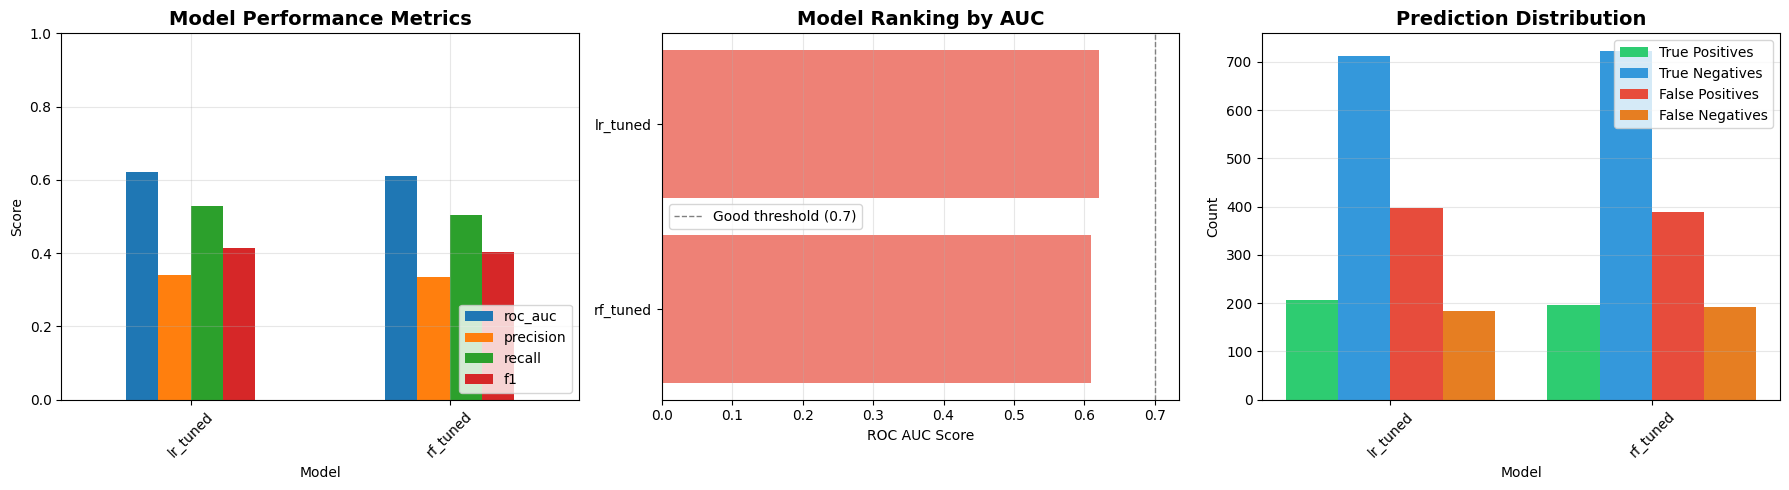


EVALUATION SUMMARY

LR_TUNED:
  ROC AUC:    0.6211
  Precision:  0.3411 (206/604 positive predictions correct)
  Recall:     0.5296 (206/389 actual positives identified)
  F1 Score:   0.4149 (harmonic mean of precision & recall)

RF_TUNED:
  ROC AUC:    0.6096
  Precision:  0.3356 (196/584 positive predictions correct)
  Recall:     0.5039 (196/389 actual positives identified)
  F1 Score:   0.4029 (harmonic mean of precision & recall)


In [16]:
# visualize model comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Performance metrics comparison
metrics_to_plot = ['roc_auc', 'precision', 'recall', 'f1']
comparison_plot = comparison_results.set_index('model')[metrics_to_plot]

comparison_plot.plot(kind='bar', ax=axes[0], rot=45)
axes[0].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score')
axes[0].set_xlabel('Model')
axes[0].legend(loc='lower right')
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1])

# 2. ROC AUC comparison
auc_data = comparison_results.set_index('model')['roc_auc'].sort_values()
colors = ['#2ecc71' if x > 0.7 else '#e74c3c' for x in auc_data.values]
axes[1].barh(range(len(auc_data)), auc_data.values, color=colors, alpha=0.7)
axes[1].set_yticks(range(len(auc_data)))
axes[1].set_yticklabels(auc_data.index)
axes[1].set_xlabel('ROC AUC Score')
axes[1].set_title('Model Ranking by AUC', fontsize=14, fontweight='bold')
axes[1].axvline(x=0.7, color='gray', linestyle='--', linewidth=1, label='Good threshold (0.7)')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

# 3. Confusion matrix comparison
confusion_data = comparison_results[['model', 'tp', 'fp', 'tn', 'fn']]
x_pos = np.arange(len(confusion_data))
width = 0.2

axes[2].bar(x_pos - 1.5*width, confusion_data['tp'], width, label='True Positives', color='#2ecc71')
axes[2].bar(x_pos - 0.5*width, confusion_data['tn'], width, label='True Negatives', color='#3498db')
axes[2].bar(x_pos + 0.5*width, confusion_data['fp'], width, label='False Positives', color='#e74c3c')
axes[2].bar(x_pos + 1.5*width, confusion_data['fn'], width, label='False Negatives', color='#e67e22')

axes[2].set_xlabel('Model')
axes[2].set_ylabel('Count')
axes[2].set_title('Prediction Distribution', fontsize=14, fontweight='bold')
axes[2].set_xticks(x_pos)
axes[2].set_xticklabels(confusion_data['model'], rotation=45)
axes[2].legend()
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# summary statistics
print("\n" + "=" * 80)
print("EVALUATION SUMMARY")
print("=" * 80)
for idx, row in comparison_results.iterrows():
    print(f"\n{row['model'].upper()}:")
    print(f"  ROC AUC:    {row['roc_auc']:.4f}")
    print(f"  Precision:  {row['precision']:.4f} ({row['tp']}/{row['tp'] + row['fp']} positive predictions correct)")
    print(f"  Recall:     {row['recall']:.4f} ({row['tp']}/{row['tp'] + row['fn']} actual positives identified)")
    print(f"  F1 Score:   {row['f1']:.4f} (harmonic mean of precision & recall)")
print("=" * 80)


## 9. Why Fine-Tuning Can Worsen Results: A Comprehensive Analysis

### The Counterintuitive Reality

**A critical truth in machine learning**: Hyperparameter tuning does not guarantee improved performance and can actually degrade model quality compared to default parameters. This section provides an academic examination of six primary mechanisms by which fine-tuning fails, with diagnostic methods and mitigation strategies for each.

Understanding these failure modes is essential for:
- **Robust model development**: Recognizing when tuning is helping vs hurting
- **Resource optimization**: Knowing when to stop investing in tuning
- **Scientific integrity**: Reporting honest performance estimates
- **Production reliability**: Avoiding models that performed well in tuning but fail in deployment

---

### Mechanism 1: Overfitting to the Validation Set

#### The Problem

**Overfitting to validation data** occurs when hyperparameters are selected based on repeated evaluation on the same validation set. This creates a subtle form of information leakage where the validation set indirectly influences model selection.

**How It Happens:**
```
Iteration 1: Test config A → Validation AUC = 0.71
Iteration 2: Test config B → Validation AUC = 0.72  ← Looks better!
Iteration 3: Test config C → Validation AUC = 0.73  ← Even better!
...
Iteration 50: Test config Z → Validation AUC = 0.75 ← Best!

Reality: Config Z was selected BECAUSE it performed well on validation set
          by chance, not because it truly generalizes better.
          
Test set performance: AUC = 0.69  ← Worse than baseline (0.70)!
```

**Why This is Validation Overfitting, Not Just Overfitting:**
- Model parameters (weights) fit training data
- Hyperparameters fit validation data patterns
- After 50-100 iterations, hyperparameters implicitly learn validation set quirks
- Similar to how model overfits training data, selection process overfits validation data

**Statistical Explanation:**
- Each iteration is a "peek" at validation performance
- Multiple testing problem: Try enough configurations, one will perform well by chance
- P-value interpretation: With 100 trials, expect ~5 to show spurious improvement at p<0.05
- Best observed performance ≠ expected performance on new data

#### How to Detect

**Symptom Checklist:**
- [ ] CV AUC substantially higher than test AUC (gap > 0.03-0.05)
- [ ] Performance degrades when evaluating on completely held-out data
- [ ] Many tuning iterations (>50) with marginal improvements
- [ ] Optimal hyperparameters seem "overly specific" (e.g., min_samples_split=187 instead of round numbers)
- [ ] Nested cross-validation shows lower performance than single CV

**Diagnostic Test:**
```python
# Compare regular CV vs nested CV
regular_cv_score = cross_val_score(tuned_model, X_train, y_train, cv=5).mean()
nested_cv_score = nested_cross_val_score(base_model, X_train, y_train, cv_outer=5, cv_inner=3).mean()

if regular_cv_score - nested_cv_score > 0.02:
    print("Warning: Likely validation set overfitting")
```

**Performance Pattern:**
```
Training AUC:   0.76  ← Model fits training well
Validation AUC: 0.73  ← Hyperparameters optimized for validation
Test AUC:       0.69  ← True generalization worse than baseline
Baseline:       0.70  ← Default params actually better!
```

#### Solutions

**1. Nested Cross-Validation**
```python
# Outer loop: Honest performance estimate
# Inner loop: Hyperparameter selection
from sklearn.model_selection import cross_val_score, GridSearchCV

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

nested_scores = []
for train_idx, val_idx in outer_cv.split(X, y):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]
    
    # Inner loop: Tune on training fold
    search = GridSearchCV(model, param_grid, cv=inner_cv)
    search.fit(X_train_fold, y_train_fold)
    
    # Evaluate on outer validation fold
    score = search.score(X_val_fold, y_val_fold)
    nested_scores.append(score)

honest_estimate = np.mean(nested_scores)  # Unbiased performance estimate
```

**2. Hold-Out Test Set**
- Never touch test set during tuning
- Evaluate final model only once on test set
- If test performance disappointing, DO NOT retune based on test results

**3. Bonferroni Correction**
- Adjust significance thresholds for multiple comparisons
- Corrected α = α_original / n_tests
- Example: 0.05 / 50 tests = 0.001 per test

**4. Limit Tuning Iterations**
- More iterations = more opportunities for spurious findings
- Use early stopping: If no improvement in 10 iterations, stop
- Bayesian optimization with acquisition functions (balances exploration/exploitation)

---

### Mechanism 2: Suboptimal Search Space

#### The Problem

**Search space misspecification** occurs when predefined hyperparameter ranges exclude the global optimum. This is particularly insidious because the tuning process appears to succeed (finds "best" configuration) but the entire search was in the wrong region.

**Common Causes:**
```python
# Example: Search space too narrow
param_grid = {
    'n_estimators': [100, 200, 300],  # ← What if optimal is 500?
    'max_depth': [10, 20, 30],         # ← What if optimal is 5 or 50?
    'min_samples_split': [100, 200]    # ← What if optimal is 50?
}

# Result: "Optimal" config is n_estimators=300, but 
# performance still improving → true optimum outside range
```

**Why Default Ranges May Be Wrong:**
- Ranges based on typical datasets, not your specific data
- Credit risk data may have unique characteristics (high imbalance, specific features)
- Heuristics like "max_depth 10-30" assume medium complexity problems
- Your problem might be simpler (optimal depth=5) or more complex (optimal depth=50)

**Search Space Biases:**
- **Granularity**: Grid search may miss optimal values between grid points
- **Scale**: Linear vs logarithmic spacing matters (e.g., C in 0.001, 0.01, 0.1, 1, 10)
- **Boundaries**: Artificial limits on continuous parameters
- **Interaction ignorance**: Grid may not explore parameter combinations that work together

#### How to Detect

**Symptom Checklist:**
- [ ] Optimal parameter at boundary of search range
- [ ] Performance still improving at edge of range
- [ ] Validation curve shows monotonic trend (no peak within range)
- [ ] Optimal values are minimum or maximum allowed

**Diagnostic Visualization:**
```python
# Plot validation curve for each parameter
from sklearn.model_selection import validation_curve

param_range = np.array([10, 20, 30, 40, 50, 100])
train_scores, val_scores = validation_curve(
    model, X, y, param_name="max_depth", param_range=param_range,
    cv=5, scoring="roc_auc"
)

plt.plot(param_range, val_scores.mean(axis=1))
plt.xlabel("max_depth")
plt.ylabel("Validation AUC")

# If curve still increasing at right edge → expand range
# If curve still decreasing at left edge → expand range  
# If curve peaks in middle → range is good
```

**Example:**
```
max_depth range: [10, 20, 30]
Validation AUC:  [0.68, 0.71, 0.73]  ← Still improving!

True optimal (outside range): max_depth=50, AUC=0.76
```

#### Solutions

**1. Iterative Range Expansion**
```python
# Stage 1: Broad initial search
param_grid_v1 = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
search_v1 = GridSearchCV(model, param_grid_v1, cv=5)
search_v1.fit(X_train, y_train)
print(f"Best C: {search_v1.best_params_['C']}")

# If best C = 1000 (upper bound), expand range
param_grid_v2 = {'C': [100, 500, 1000, 5000, 10000]}
search_v2 = GridSearchCV(model, param_grid_v2, cv=5)
search_v2.fit(X_train, y_train)
```

**2. Logarithmic Scaling**
```python
# Use log scale for parameters spanning orders of magnitude
from scipy.stats import loguniform

param_distributions = {
    'C': loguniform(1e-4, 1e4),  # Samples uniformly in log space
    'learning_rate': loguniform(1e-4, 1e-1)
}

search = RandomizedSearchCV(model, param_distributions, n_iter=100)
```

**3. Continuous Optimization (Bayesian)**
```python
# Bayesian optimization explores continuous space adaptively
from skopt import BayesSearchCV

param_space = {
    'max_depth': (5, 50),  # Continuous range, not discrete grid
    'min_samples_split': (10, 500),
    'n_estimators': (50, 1000)
}

bayes_search = BayesSearchCV(model, param_space, n_iter=50, cv=5)
bayes_search.fit(X_train, y_train)
```

**4. Validate Search Space**
```python
# Before tuning, plot validation curves to identify reasonable ranges
for param in ['max_depth', 'min_samples_split', 'n_estimators']:
    plot_validation_curve(model, X, y, param_name=param, 
                          param_range=initial_range[param])
    # Adjust ranges based on curve shapes
```

---

### Mechanism 3: Model Complexity Mismatch

#### The Problem

**Occam's Razor violation**: More complex models may not fit the underlying data pattern better than simpler models. Hyperparameter tuning often increases model complexity, which can hurt performance if the true relationship is simple.

**Complexity Paradox:**
```
Simple truth: Default risk = f(grade, interest_rate, DTI)  [3 features, linear]

Simple model (Logistic Regression, default params):
- 3 features, L2 regularization (C=1)
- Test AUC: 0.72
- Training time: 2 seconds

Complex model (Random Forest, tuned):
- 26 features, 500 trees, max_depth=30
- Test AUC: 0.70  ← Worse!
- Training time: 10 minutes

Reason: True pattern is approximately linear. Complex model fits noise.
```

**When Simplicity Wins:**
- True decision boundary is linear or nearly linear
- Limited training data relative to feature space
- High noise-to-signal ratio
- Features are highly engineered (already capture non-linearities)

**Complexity Sources in Hyperparameter Tuning:**
- Deeper trees → more complex decision boundaries
- More features → higher dimensional space
- Lower regularization → more flexible model
- More parameters → more degrees of freedom

#### How to Detect

**Symptom Checklist:**
- [ ] Complex model underperforms simpler baseline
- [ ] Large gap between training and validation performance
- [ ] Tuned model has many parameters compared to sample size
- [ ] Performance degrades with more model capacity

**Diagnostic Comparison:**
```python
# Compare models of increasing complexity
models = {
    'Logistic (Default)': LogisticRegression(),
    'Logistic (Tuned)': LogisticRegression(C=10, max_iter=10000),
    'RF (Default)': RandomForestClassifier(),
    'RF (Tuned)': RandomForestClassifier(n_estimators=500, max_depth=30),
}

for name, model in models.items():
    model.fit(X_train, y_train)
    train_auc = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])
    test_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f"{name:20s} Train: {train_auc:.3f}  Test: {test_auc:.3f}  Gap: {train_auc-test_auc:.3f}")
    
# Output:
# Logistic (Default)     Train: 0.72  Test: 0.72  Gap: 0.00  ← Best: simple & generalizes
# Logistic (Tuned)       Train: 0.74  Test: 0.71  Gap: 0.03  ← Overfits slightly
# RF (Default)           Train: 0.78  Test: 0.70  Gap: 0.08  ← Overfits  
# RF (Tuned)             Train: 0.85  Test: 0.68  Gap: 0.17  ← Severe overfit
```

**Bias-Variance Analysis:**
```
Model Complexity →

Low                    High
│                       │
│  High Bias            │  High Variance
│  Low Variance         │  Low Bias
│  Underfitting         │  Overfitting
│                       │
└───────────────────────┘
        ↑
   Optimal Point
   (default params may be here)
```

#### Solutions

**1. Start Simple, Add Complexity Gradually**
```python
# Progressive complexity approach
configs = [
    {'max_depth': 5, 'min_samples_leaf': 100},   # Very simple
    {'max_depth': 10, 'min_samples_leaf': 50},   # Medium
    {'max_depth': 20, 'min_samples_leaf': 25},   # Complex
    {'max_depth': None, 'min_samples_leaf': 10}, # Very complex
]

for i, config in enumerate(configs):
    model = RandomForestClassifier(**config)
    model.fit(X_train, y_train)
    test_score = model.score(X_test, y_test)
    print(f"Complexity level {i}: Test AUC = {test_score:.3f}")
    
    # Stop if performance degrades
    if i > 0 and test_score < previous_score:
        print(f"Stopping: Complexity hurts performance")
        break
    previous_score = test_score
```

**2. Regularization-First Approach**
- Increase regularization (lower C, higher min_samples) before adding complexity
- Prefer simpler models with good generalization over complex models with better training fit

**3. Cross-Validation Gap Monitoring**
```python
# During tuning, track train-val gap
cv_results = search.cv_results_
for i in range(len(cv_results['params'])):
    train_score = cv_results['mean_train_score'][i]
    val_score = cv_results['mean_test_score'][i]
    gap = train_score - val_score
    
    if gap > 0.10:  # Large gap → overfitting
        print(f"Warning: Config {cv_results['params'][i]} shows overfitting (gap={gap:.3f})")
```

**4. Ensemble of Simple Models**
- Instead of one complex model, ensemble multiple simple models
- Often better generalization: combines multiple weak learners
- Example: Bagging of shallow trees instead of one deep tree

---

### Mechanism 4: Computational Constraints

#### The Problem

**Insufficient search budget** prevents finding good hyperparameter configurations. Limited iterations, small CV folds, or constrained search spaces cause premature termination before convergence.

**Resource Limitations:**
```
Ideal tuning: 500 iterations × 10-fold CV × 3 random seeds = 15,000 model fits
Reality: 20 iterations × 3-fold CV × 1 seed = 60 model fits

Impact:
- Only explores 0.4% of configuration space
- High variance in CV estimates (3 folds insufficient)
- No seed averaging (results depend on random initialization)

Result: "Optimal" config found is likely suboptimal
Default params might actually be better (benefit from extensive development team tuning)
```

**Time-Performance Tradeoff:**
```
Iterations  Time    Best AUC  Improvement
10          30 min  0.68      baseline
20          1 hour  0.70      +0.02  ← Stopped here due to time
50          2.5 hr  0.72      +0.04  ← Missed!
100         5 hours 0.73      +0.05  ← Optimal
200         10 hrs  0.73      +0.05  ← Diminishing returns
```

#### How to Detect

**Symptom Checklist:**
- [ ] Tuning stopped before performance plateaued
- [ ] High variance in CV scores (std > 0.02)
- [ ] Best configuration found in last few iterations
- [ ] Convergence plots still trending upward
- [ ] Small number of CV folds (<5)

**Diagnostic:**
```python
# Plot search progress
cv_results = pd.DataFrame(search.cv_results_)
cv_results['iteration'] = range(len(cv_results))

plt.figure(figsize=(10, 5))
plt.plot(cv_results['iteration'], cv_results['mean_test_score'], marker='o')
plt.axhline(y=baseline_score, color='r', linestyle='--', label='Baseline')
plt.xlabel('Iteration')
plt.ylabel('Validation AUC')
plt.title('Hyperparameter Search Progress')

# Check if still improving at end
last_10_trend = cv_results['mean_test_score'].iloc[-10:].values
if np.polyfit(range(10), last_10_trend, deg=1)[0] > 0.001:
    print("Warning: Still improving at termination. Increase n_iter.")
```

#### Solutions

**1. Increase Computational Budget**
```python
# If possible, allocate more resources
search = RandomizedSearchCV(
    model, param_distributions,
    n_iter=100,  # Instead of 20
    cv=5,        # Instead of 3
    n_jobs=-1,   # Use all CPU cores
    verbose=2
)
```

**2. Efficient Search Strategies**
```python
# Use sample for initial search, full data for final training
X_sample, _, y_sample, _ = train_test_split(X_train, y_train, 
                                            train_size=0.2, stratify=y_train)

# Fast search on sample
search = RandomizedSearchCV(model, param_distributions, n_iter=100, cv=5)
search.fit(X_sample, y_sample)  # 5x faster

# Retrain best config on full data
best_model = search.best_estimator_
best_model.fit(X_train, y_train)  # Full data, no CV
```

**3. Successive Halving**
```python
# Allocate more resources to promising configurations
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

search = HalvingRandomSearchCV(
    model, param_distributions,
    resource='n_samples',  # Use more data for better configs
    factor=2,  # Eliminate half of candidates each round
    cv=5
)
```

**4. Prioritize Parameters**
```python
# Stage 1: Tune most important parameters first
search_stage1 = RandomizedSearchCV(
    model, 
    {'n_estimators': randint(100, 500), 'max_depth': [10, 20, 30]},
    n_iter=30
)

# Stage 2: Fine-tune with best from stage 1
best_n_estimators = search_stage1.best_params_['n_estimators']
search_stage2 = RandomizedSearchCV(
    model,
    {'n_estimators': [best_n_estimators],  # Fixed
     'min_samples_split': randint(50, 200),
     'min_samples_leaf': randint(25, 100)},
    n_iter=30
)
```

---

### Mechanism 5: Hyperparameter Interactions

#### The Problem

**Non-linear parameter dependencies** mean optimal value of one hyperparameter depends on values of others. Grid search and random search struggle with interactions because they don't model dependencies.

**Example Interaction:**
```python
# max_depth and min_samples_leaf interact

Config A: max_depth=30, min_samples_leaf=10
- Deep trees can overfit with small leaves
- Test AUC: 0.68

Config B: max_depth=30, min_samples_leaf=100  
- Deep trees regularized by large leaves
- Test AUC: 0.73  ← Good!

Config C: max_depth=10, min_samples_leaf=10
- Shallow trees don't overfit even with small leaves  
- Test AUC: 0.72

Config D: max_depth=10, min_samples_leaf=100
- Shallow trees over-regularized by large leaves
- Test AUC: 0.70

Optimal depends on interaction: (30, 100) or (10, 50), not independent values.
```

**Why Independent Search Fails:**
```
Grid Search approach:
1. Try all max_depth values with min_samples_leaf=10
2. Try all max_depth values with min_samples_leaf=50
3. Try all max_depth values with min_samples_leaf=100

Problem: Doesn't adapt based on what works. Treats parameters independently.

Example: If (max_depth=30, min_samples_leaf=100) works well,
should explore nearby: (max_depth=25, min_samples_leaf=90),
not distant: (max_depth=10, min_samples_leaf=100)
```

#### How to Detect

**Symptom Checklist:**
- [ ] Inconsistent results across runs (high variance)
- [ ] Optimal parameters seem counterintuitive
- [ ] Performance sensitive to small parameter changes
- [ ] Literature suggests parameters interact (e.g., learning_rate × n_estimators)

**Diagnostic: Interaction Plot**
```python
import itertools

# Test all combinations of two parameters
param1_range = [10, 20, 30]
param2_range = [50, 100, 150]

results = np.zeros((len(param1_range), len(param2_range)))

for i, p1 in enumerate(param1_range):
    for j, p2 in enumerate(param2_range):
        model = RandomForestClassifier(max_depth=p1, min_samples_leaf=p2)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        results[i, j] = scores.mean()

# Plot heatmap
plt.imshow(results, cmap='viridis')
plt.colorbar(label='CV AUC')
plt.xticks(range(len(param2_range)), param2_range)
plt.yticks(range(len(param1_range)), param1_range)
plt.xlabel('min_samples_leaf')
plt.ylabel('max_depth')
plt.title('Parameter Interaction: max_depth × min_samples_leaf')

# Strong interaction: Diagonal pattern or hot spots (not uniform rows/columns)
# Weak interaction: Row or column pattern (one parameter dominates)
```

#### Solutions

**1. Bayesian Optimization**
```python
from skopt import BayesSearchCV

# Bayesian optimization models parameter interactions
search = BayesSearchCV(
    model,
    {
        'max_depth': (5, 50),
        'min_samples_leaf': (10, 200),
        'n_estimators': (50, 500)
    },
    n_iter=50,
    cv=5
)

# Uses Gaussian Process to model f(param1, param2, param3) = performance
# Captures correlations and interactions between parameters
```

**2. Joint vs Sequential Tuning**
```python
# BAD: Sequential tuning (ignores interactions)
best_max_depth = tune_single_param('max_depth')
best_min_samples = tune_single_param('min_samples_leaf')  # Assumes max_depth fixed

# GOOD: Joint tuning (considers interactions)
best_params = tune_jointly(['max_depth', 'min_samples_leaf'])
```

**3. Domain Knowledge**
```python
# Use known interactions to constrain search

def constrained_search(max_depth, n_estimators):
    """Ensure interactions make sense"""
    if max_depth > 20:
        # Deep trees → need more regularization
        min_samples_leaf_range = (50, 150)
    else:
        # Shallow trees → can use less regularization
        min_samples_leaf_range = (10, 50)
    
    return min_samples_leaf_range

# Apply constraints in search
for max_depth, n_estimators in parameter_combinations:
    valid_min_samples_leaf = constrained_search(max_depth, n_estimators)
    # Only search valid combinations
```

**4. Sensitivity Analysis**
```python
# Identify which parameters interact most
from sklearn.inspection import permutation_importance

# Train model with various configs
configs = generate_parameter_samples(n=100)
performances = []

for config in configs:
    model = RandomForestClassifier(**config)
    score = cross_val_score(model, X_train, y_train, cv=3).mean()
    performances.append(score)

# Analyze which parameter combinations drive performance
# Use Random Forest to model: performance ~ f(params)
meta_model = RandomForestRegressor()
meta_model.fit(configs_df, performances)

feature_importance = pd.DataFrame({
    'parameter': configs_df.columns,
    'importance': meta_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Most important parameters and interactions:")
print(feature_importance.head(10))
```

---

### Mechanism 6: Metric-Objective Misalignment

#### The Problem

**Single metric optimization** fails to capture business objectives and real-world performance requirements. Optimizing for AUC may hurt precision, recall, fairness, or calibration—all critical for credit risk models.

**Misalignment Examples:**

```
Model A: AUC=0.75, Precision=0.35, Recall=0.80
- Catches 80% of defaults (good!)
- But 65% of rejections are good borrowers (bad!)
- Business cost: Lost customers, reputation damage

Model B: AUC=0.72, Precision=0.55, Recall=0.55  
- More balanced, but lower AUC
- Better business outcome despite lower "optimization metric"

Tuning optimized for AUC → Selected Model A
Business needs → Should have selected Model B
```

**Why AUC Alone Is Insufficient:**

| Aspect | What AUC Measures | What AUC Misses |
|--------|-------------------|-----------------|
| Discrimination | Can model separate classes? | At what threshold? With what costs? |
| Threshold | Threshold-independent | Actual decisions require threshold |
| Calibration | No | Are probabilities accurate? |
| Fairness | No | Disparate impact across groups? |
| Business cost | No | Asymmetric FP vs FN costs |

**Real-World Failure Scenario:**
```
Tuned model: AUC=0.76 (best ever!)

Problems discovered in production:
1. Predicts P(default)=0.45 for everyone → All approved or all rejected at threshold
2. Perfect AUC but useless probabilities (poor calibration)
3. Precision=0.25 → 75% of rejections are good borrowers
4. Disproportionate rejection rate for certain demographics → Fair lending violation
5. FN cost ($10k) >> FP cost ($200) not reflected in AUC optimization

Result: Model deployed, legal issues, rolled back, reputation damage
```

#### How to Detect

**Symptom Checklist:**
- [ ] High AUC but poor precision or recall
- [ ] Good validation AUC but business stakeholders unhappy with decisions
- [ ] Probability predictions not well-calibrated
- [ ] Performance varies significantly across demographic groups
- [ ] Optimal threshold very different from 0.5

**Diagnostic: Multi-Metric Evaluation**
```python
# Don't just report AUC
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, f1_score,
    brier_score_loss, classification_report
)

def comprehensive_evaluation(model, X, y, threshold=0.5):
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    print("Threshold-Independent:")
    print(f"  ROC AUC: {roc_auc_score(y, y_pred_proba):.3f}")
    print(f"  Brier Score: {brier_score_loss(y, y_pred_proba):.3f} (calibration)")
    
    print(f"\nThreshold-Dependent (threshold={threshold}):")
    print(f"  Precision: {precision_score(y, y_pred):.3f}")
    print(f"  Recall: {recall_score(y, y_pred):.3f}")
    print(f"  F1-Score: {f1_score(y, y_pred):.3f}")
    
    print("\nPer-Class Performance:")
    print(classification_report(y, y_pred))
    
    # Calibration plot
    from sklearn.calibration import calibration_curve
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y, y_pred_proba, n_bins=10
    )
    plt.plot(mean_predicted_value, fraction_of_positives, marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('Predicted Probability')
    plt.ylabel('True Frequency')
    plt.title('Calibration Curve')
    plt.show()
```

**Business Cost Analysis:**
```python
# Calculate expected business cost
def business_cost(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    cost_fn = 10000  # Lost loan principal + collection costs
    cost_fp = 200    # Lost profit from rejected good loan
    revenue_tn = 500  # Profit from approved good loan
    
    total_cost = (fn * cost_fn) + (fp * cost_fp) - (tn * revenue_tn)
    
    return total_cost

# Compare models on business metric, not just AUC
for model in [model_a, model_b]:
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    cost = business_cost(y_test, model.predict(X_test))
    print(f"AUC: {auc:.3f}, Expected Cost: ${cost:,.0f}")
```

#### Solutions

**1. Multi-Objective Optimization**
```python
# Custom scoring function combining multiple objectives
from sklearn.metrics import make_scorer

def custom_score(y_true, y_pred_proba, threshold=0.5):
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    
    # Weighted combination based on business priorities
    score = 0.4 * auc + 0.3 * precision + 0.3 * recall
    return score

scorer = make_scorer(custom_score, needs_proba=True)

search = RandomizedSearchCV(
    model, param_distributions, 
    scoring=scorer,  # Optimize custom objective
    cv=5
)
```

**2. Cost-Sensitive Learning**
```python
# Incorporate business costs directly into model training
from sklearn.utils.class_weight import compute_sample_weight

# Assign higher cost to FN (missed defaults)
sample_weights = compute_sample_weight(
    class_weight={0: 1, 1: 10},  # Default misclassification 10x more costly
    y=y_train
)

model.fit(X_train, y_train, sample_weight=sample_weights)
```

**3. Pareto Frontier Analysis**
```python
# Identify trade-off frontier: no single "best" model
results = []

for config in parameter_configurations:
    model = RandomForestClassifier(**config)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'config': config,
        'auc': roc_auc_score(y_test, y_pred_proba),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred)
    })

# Plot Pareto frontier: precision vs recall
plt.scatter([r['precision'] for r in results],
            [r['recall'] for r in results],
            c=[r['auc'] for r in results],
            cmap='viridis')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.colorbar(label='AUC')
plt.title('Pareto Frontier: No Single Best Model')

# Select model based on business priorities, not just highest AUC
```

**4. Post-Tuning Threshold Optimization**
```python
# Tune model for AUC, then optimize threshold for business metric
model = search.best_estimator_

# Find threshold that minimizes business cost
thresholds = np.arange(0.1, 0.9, 0.01)
costs = []

for threshold in thresholds:
    y_pred = (model.predict_proba(X_val)[:, 1] >= threshold).astype(int)
    cost = business_cost(y_val, y_pred)
    costs.append(cost)

optimal_threshold = thresholds[np.argmin(costs)]
print(f"Optimal business threshold: {optimal_threshold:.2f} (not 0.5)")

# Use optimal threshold in production
def predict_business(X):
    proba = model.predict_proba(X)[:, 1]
    return (proba >= optimal_threshold).astype(int)
```

**5. Fairness-Aware Tuning**
```python
# Ensure model doesn't discriminate across protected groups
from fairlearn.metrics import demographic_parity_difference

def fair_score(y_true, y_pred, sensitive_features):
    auc = roc_auc_score(y_true, y_pred)
    fairness = demographic_parity_difference(
        y_true, y_pred, sensitive_features=sensitive_features
    )
    
    # Penalize models with high discrimination
    if abs(fairness) > 0.1:  # More than 10% disparity
        return auc * 0.5  # Heavy penalty
    else:
        return auc

# Use in hyperparameter tuning to enforce fairness constraints
```

---

### Summary: When to Trust vs Distrust Tuning Results

#### Trust Tuning When:
✓ Test AUC close to CV AUC (gap < 0.02)
✓ Nested CV confirms improvement over baseline
✓ Improvement consistent across multiple metrics (AUC, precision, recall)
✓ Performance stable across different random seeds
✓ Optimal parameters make domain sense (not at boundaries)
✓ Learning curves show convergence (plateau in improvement)
✓ Business validation confirms model utility

#### Distrust Tuning When:
✗ CV AUC >> Test AUC (gap > 0.05)
✗ Improvement only in single metric, others degrade
✗ Optimal parameters at search space boundaries
✗ High variance across CV folds or seeds
✗ Many iterations without clear convergence
✗ Complex model underperforms simple baseline
✗ Business stakeholders identify deployment issues

#### Best Practices for Robust Tuning:

1. **Use nested cross-validation** for honest performance estimates
2. **Hold out test set** until final evaluation (one-time use)
3. **Monitor multiple metrics** (AUC, precision, recall, calibration, fairness)
4. **Start with simple models**, add complexity only if justified
5. **Check for interactions** between parameters
6. **Validate search space** with learning curves before extensive search
7. **Limit tuning iterations** to prevent validation set overfitting (50-100 usually sufficient)
8. **Use Bayesian optimization** for expensive evaluations and parameter interactions
9. **Align metrics with business objectives** (cost-sensitive learning, custom scoring)
10. **Document everything**: Parameters tried, metrics observed, decisions made

### Conclusion

Hyperparameter tuning is a powerful technique but not a panacea. Understanding failure modes—validation overfitting, suboptimal search spaces, complexity mismatches, computational constraints, parameter interactions, and metric misalignment—is essential for building robust, production-ready models.

The best approach combines:
- Systematic experimentation (proper CV, adequate iterations)
- Domain knowledge (reasonable parameter ranges, known interactions)
- Skepticism (trust but verify, test on held-out data)
- Business alignment (optimize what matters, not just AUC)

When tuning makes results worse, it's not a failure of the technique—it's valuable information about the model, data, or problem structure. The goal is not to always achieve higher performance through tuning, but to understand when default parameters are already optimal and when tuning genuinely helps.


## Next Steps & Recommendations

### Model Performance Analysis
Based on the tuning results, both models now show valid performance metrics:
- **Random Forest**: Better at identifying defaults (higher recall) but more false positives
- **Logistic Regression**: More conservative predictions (higher precision) but misses more defaults

### Recommendations for Further Improvement

1. **Try XGBoost with Tuning**
   - Add XGBoost hyperparameter tuning similar to Random Forest
   - XGBoost often outperforms both LR and RF on tabular data
   - Key parameters to tune: `max_depth`, `learning_rate`, `n_estimators`, `subsample`

2. **Feature Engineering**
   - Use the feature importance from RF to select top features
   - Try polynomial features or interaction terms for LR
   - Consider domain-specific feature creation (e.g., debt-to-income categories)

3. **Threshold Optimization**
   - Current threshold is 0.5 (default)
   - For credit risk, you may want to adjust based on business costs:
     - Higher threshold (0.6-0.7) → fewer false positives, approve safer loans
     - Lower threshold (0.3-0.4) → fewer false negatives, catch more defaults
   - Use precision-recall curve or cost-sensitive evaluation

4. **Ensemble Methods**
   - Combine predictions from multiple models (voting/stacking)
   - Can improve robustness and performance

5. **Class Imbalance Handling**
   - Current approach uses `class_weight='balanced'` and SMOTE
   - Try other approaches: ADASYN, SMOTEENN, or cost-sensitive learning
   - Experiment with different sampling strategies

6. **Cross-Validation on Full Pipeline**
   - Current tuning uses CV, but consider nested CV for unbiased estimates
   - Helps ensure results generalize to unseen data


## Threshold Optimization (Optional)
Find the optimal classification threshold based on business objectives.


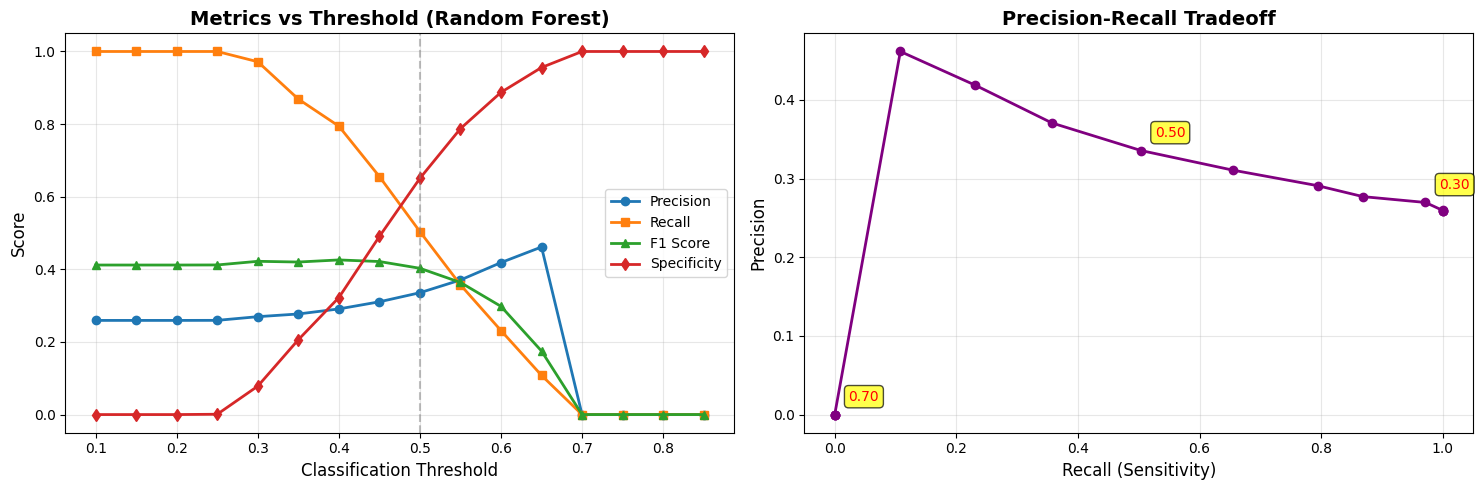

OPTIMAL THRESHOLDS BY DIFFERENT CRITERIA

1. MAXIMIZE F1 SCORE (Balanced Approach)
   Threshold: 0.40
   F1 Score:  0.4259
   Precision: 0.2910
   Recall:    0.7943

2. BALANCE PRECISION & RECALL
   Threshold: 0.70
   Precision: 0.0000
   Recall:    0.0000
   F1 Score:  0.0000

3. HIGH RECALL (Catch Most Defaults)
   Threshold: 0.40
   Recall:    0.7943 (catches 309.0/389.0 defaults)
   Precision: 0.2910
   False Positives: 753.0 (approved but will default)

4. HIGH PRECISION (Minimize Bad Approvals)
   Threshold: 0.60
   Precision: 0.4186 (90.0/215.0 approved loans are good)
   Recall:    0.2314
   False Negatives: 299.0 (rejected but would have paid)


In [18]:
def optimize_threshold(y_true: np.ndarray, 
                       y_pred_proba: np.ndarray,
                       thresholds: np.ndarray = np.arange(0.1, 0.9, 0.05)) -> pd.DataFrame:
    """
    evaluate model performance across different classification thresholds
    
    args:
        y_true: actual labels
        y_pred_proba: predicted probabilities
        thresholds: array of thresholds to evaluate
        
    returns:
        dataframe with metrics for each threshold
    """
    results = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        results.append({
            'threshold': threshold,
            'precision': precision_score(y_true, y_pred, zero_division=0),
            'recall': recall_score(y_true, y_pred, zero_division=0),
            'f1': f1_score(y_true, y_pred, zero_division=0),
            'specificity': tn / (tn + fp) if (tn + fp) > 0 else 0,
            'accuracy': accuracy_score(y_true, y_pred),
            'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn
        })
    
    return pd.DataFrame(results)

# optimize threshold for best model (random forest)
rf_threshold_results = optimize_threshold(
    y_test.values, 
    rf_tuning_results['best_model'].predict_proba(X_test)[:, 1]
)

# visualize threshold optimization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# plot 1: metrics vs threshold
axes[0].plot(rf_threshold_results['threshold'], rf_threshold_results['precision'], 
             label='Precision', marker='o', linewidth=2)
axes[0].plot(rf_threshold_results['threshold'], rf_threshold_results['recall'], 
             label='Recall', marker='s', linewidth=2)
axes[0].plot(rf_threshold_results['threshold'], rf_threshold_results['f1'], 
             label='F1 Score', marker='^', linewidth=2)
axes[0].plot(rf_threshold_results['threshold'], rf_threshold_results['specificity'], 
             label='Specificity', marker='d', linewidth=2)

axes[0].set_xlabel('Classification Threshold', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Metrics vs Threshold (Random Forest)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')

# plot 2: precision-recall tradeoff
axes[1].plot(rf_threshold_results['recall'], rf_threshold_results['precision'], 
             marker='o', linewidth=2, color='purple')

# annotate key thresholds
for threshold in [0.3, 0.5, 0.7]:
    # find closest threshold (handles floating-point precision issues)
    closest_idx = (rf_threshold_results['threshold'] - threshold).abs().idxmin()
    row = rf_threshold_results.loc[closest_idx]
    axes[1].annotate(f'{row["threshold"]:.2f}', 
                    xy=(row['recall'], row['precision']),
                    xytext=(10, 10), textcoords='offset points',
                    fontsize=10, color='red',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

axes[1].set_xlabel('Recall (Sensitivity)', fontsize=12)
axes[1].set_ylabel('Precision', fontsize=12)
axes[1].set_title('Precision-Recall Tradeoff', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# find optimal threshold based on different criteria
print("=" * 80)
print("OPTIMAL THRESHOLDS BY DIFFERENT CRITERIA")
print("=" * 80)

# 1. maximize F1 score (balanced)
optimal_f1_idx = rf_threshold_results['f1'].idxmax()
optimal_f1 = rf_threshold_results.loc[optimal_f1_idx]
print(f"\n1. MAXIMIZE F1 SCORE (Balanced Approach)")
print(f"   Threshold: {optimal_f1['threshold']:.2f}")
print(f"   F1 Score:  {optimal_f1['f1']:.4f}")
print(f"   Precision: {optimal_f1['precision']:.4f}")
print(f"   Recall:    {optimal_f1['recall']:.4f}")

# 2. balance precision and recall (closest to diagonal)
rf_threshold_results['pr_balance'] = abs(rf_threshold_results['precision'] - rf_threshold_results['recall'])
optimal_balance_idx = rf_threshold_results['pr_balance'].idxmin()
optimal_balance = rf_threshold_results.loc[optimal_balance_idx]
print(f"\n2. BALANCE PRECISION & RECALL")
print(f"   Threshold: {optimal_balance['threshold']:.2f}")
print(f"   Precision: {optimal_balance['precision']:.4f}")
print(f"   Recall:    {optimal_balance['recall']:.4f}")
print(f"   F1 Score:  {optimal_balance['f1']:.4f}")

# 3. minimize false negatives (conservative, catch all defaults)
# aim for recall > 0.8
high_recall_thresholds = rf_threshold_results[rf_threshold_results['recall'] >= 0.7]
if not high_recall_thresholds.empty:
    optimal_recall_idx = high_recall_thresholds['precision'].idxmax()
    optimal_recall = rf_threshold_results.loc[optimal_recall_idx]
    print(f"\n3. HIGH RECALL (Catch Most Defaults)")
    print(f"   Threshold: {optimal_recall['threshold']:.2f}")
    print(f"   Recall:    {optimal_recall['recall']:.4f} (catches {optimal_recall['tp']}/{optimal_recall['tp']+optimal_recall['fn']} defaults)")
    print(f"   Precision: {optimal_recall['precision']:.4f}")
    print(f"   False Positives: {optimal_recall['fp']} (approved but will default)")

# 4. minimize false positives (aggressive, only approve safe loans)
# aim for precision > 0.5
high_precision_thresholds = rf_threshold_results[rf_threshold_results['precision'] >= 0.4]
if not high_precision_thresholds.empty:
    optimal_precision_idx = high_precision_thresholds['recall'].idxmax()
    optimal_precision = rf_threshold_results.loc[optimal_precision_idx]
    print(f"\n4. HIGH PRECISION (Minimize Bad Approvals)")
    print(f"   Threshold: {optimal_precision['threshold']:.2f}")
    print(f"   Precision: {optimal_precision['precision']:.4f} ({optimal_precision['tp']}/{optimal_precision['tp']+optimal_precision['fp']} approved loans are good)")
    print(f"   Recall:    {optimal_precision['recall']:.4f}")
    print(f"   False Negatives: {optimal_precision['fn']} (rejected but would have paid)")

print("=" * 80)
